# Imports and custom functions

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from matplotlib.pyplot import figure
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from scipy import stats
import seaborn as sns
import powerlaw
from scipy.stats import poisson
from scipy.stats import norm  
from sklearn.model_selection import train_test_split
import math
import random
from random import shuffle
from scipy.stats import gmean
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
from networkx.algorithms import bipartite

def get_all_indices(mylist, myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

def closest(lst, K):
    
    number = lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]
    
    if abs(number-K) >= 3:
        print('Not close enough: ', int(abs(number-K)))
    
    # number_index = np.random.choice(get_all_indices(lst,number))
      
    return get_all_indices(lst,number) # number_index

def remove_zeros_distribution(x):

    return [i for i in x if i != 0]

def log_binning_distribution(x_i, B = 20): 
    
    x_i = remove_zeros_distribution(x_i)

    b_1 = min(x_i)
    b_Bp1 = max(x_i)
    q_1 = np.log(b_1)
    q_Bp1 = np.log(b_Bp1)
    D_q = q_Bp1 - q_1
    L_q = D_q / B

    q_list = []
    b_list = []

    for i in range(B):
        j = i + 1
        q_list.append(q_1 + (j-1)*L_q)
        b_list.append(np.exp(q_1 + (j-1)*L_q))
   
    binned_x_i = []
    density_list = []

    for i in range(len(b_list)-1):
        bin_low = b_list[i]
        bin_high = b_list[i+1]
        count_bin = 0
        for j in range(len(x_i)):
            if x_i[j] >= bin_low and x_i[j] < bin_high:
                count_bin = count_bin + 1
                
        if count_bin > 0:
            density_bin = count_bin / (len(x_i)*(bin_high-bin_low))
            density_list.append(density_bin)
            binned_x_i.append(bin_low)
        else:
            continue 
            
    return binned_x_i, density_list

def generate_network(G, node_Kd_values, kd_list, p_bind = 0.5):
    
    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(G.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(node_Kd_values[edge[0]])
        node_Kd_list_2.append(node_Kd_values[edge[1]])
    
    network_data = pd.DataFrame()
    network_data['node_1'] = node_list_1
    network_data['node_2'] = node_list_2
    network_data['node_1_Kd'] = node_Kd_list_1
    network_data['node_2_Kd'] = node_Kd_list_2
    network_data['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]

    figure(figsize=(8, 8))
    ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
    ax = sns.distplot(np.log10(list(node_Kd_values.values())), label='Generated network Nodes', norm_hist=True)
    ax = sns.distplot(np.log10(network_data['edge_Kd']), label='Generated network Edges', norm_hist=True)
    ax.set(xlabel='log Kd', ylabel='pdf')
    plt.legend()
    plt.show()

    ## Making binary labels with p_bind

    Kd_for_edges = network_data['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))

    print('Threshold: ', threshold) ## in nM

    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

    network_data['binary_label'] = binary_labels
    
    return network_data

# unipartite positive and negative layers ...k01, k10 are column vectors
def multidegree_entropy_pos_neg(k01, k10, precision=10**(-5), loops=10000):
    n=len(k01)
    t01=np.random.uniform(size=(n,1))
    t10=np.random.uniform(size=(n,1))
    oldt01=np.random.uniform(size=(n,1))
    oldt10=np.random.uniform(size=(n,1))    
    
    for kk in tqdm(range(loops)):
            T01=t01*(t01.transpose())
            T10=t10*(t10.transpose())
            Z=1+ T01 + T10
            
            #p01
            summat=(np.ones((n,1))*t01.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1, keepdims=True);
            t01=k01/(summat+(summat==0))
            T01=t01*(t01.transpose())
            
            Z=1+ T01 + T10
    
            #p10
            summat=(np.ones((n,1))*t10.transpose())/(Z+(Z==0))
            summat=summat-np.diag(np.diagonal(summat))
            summat=np.sum(summat,axis=1,keepdims=True)
            t10=k10/(summat+(summat==0))
            
            #print((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))))
            
            #print(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0))))))
            
            if np.logical_and((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))< precision),(max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))<precision)):
                break

            oldt01=t01
            oldt10=t10
            
            
    print("Loops ", kk+1)
    print('Error margin: ', max((max(abs((t01>0)*(1-t01/(oldt01+(oldt01==0)))))),max(abs((t10>0)*(1-t10/(oldt10+(oldt10==0)))))))
    T01=t01*(t01.transpose());
    T10=t10*(t10.transpose());

    Z=1+ T01 + T10;
    
    
    summat01=T01/(Z+(Z==0))
    summat01=summat01-np.diag(np.diagonal(summat01))
    k01cal=np.sum(summat01,axis=1,keepdims=True);  
    
    summat10=T10/(Z+(Z==0))
    summat10=summat10-np.diag(np.diagonal(summat10))
    k10cal=np.sum(summat10,axis=1,keepdims=True)
                    
    pconditional=summat10/(summat10+summat01+(summat10==0))
    
    return (summat01, k01cal, summat10, k10cal, pconditional)   

    return network_data

def run_configuration_model(network_data, precision=10**(-5), loops=10000):

    ## Create train-test split

    train, test = train_test_split(network_data, test_size=0.3)

    train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
    train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

    degree_train_1_0 = []
    degree_train_0_1 = []

    for node in tqdm(train_nodes):
        sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
        degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
        degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
    ## Degree ratio distirbution

    degree_ratio_list = [degree_train_1_0[i]/(degree_train_1_0[i] + degree_train_0_1[i]) for i in range(len(train_nodes))]

    figure(figsize=(8, 8))
    ax = sns.distplot(degree_ratio_list, norm_hist=True, hist_kws=dict(alpha=0.1))
    ax.set(xlim = [0,1], xlabel=r'$\rho$', ylabel='PDF')
    plt.show()

    sum_degree =  [a + b for a,b in zip(degree_train_1_0,degree_train_0_1)]
    print('Number of nodes with not positive or negative annotation: ', sum_degree.count(0))

    print('Validating p_bind value from binary labels: ', network_data['binary_label'].tolist().count(1) / len(network_data))

    summat01, k01cal, summat10, k10cal, pconditional = multidegree_entropy_pos_neg(np.array([degree_train_0_1]).T, np.array([degree_train_1_0]).T, precision=precision, loops=loops)

    test_probabilty_predicted_conditioned = []
    test_type_list = []

    ## Average conditional probability
    p10_avg = np.mean(summat10)
    p01_avg = np.mean(summat01)
    average_conditional_probability = p10_avg / (p10_avg + p01_avg)

    for index, row in tqdm(test.iterrows()):      
    
        if row['node_1'] in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = pconditional[mapped_index_in_matrix_node_1, mapped_index_in_matrix_node_2]
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Transductive')
        
        elif row['node_1'] in train_nodes and row['node_2'] not in train_nodes:
            mapped_index_in_matrix_node_1 = train_nodes_index_map[row['node_1']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_1] / (degree_train_0_1[mapped_index_in_matrix_node_1] + degree_train_1_0[mapped_index_in_matrix_node_1] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        elif row['node_1'] not in train_nodes and row['node_2'] in train_nodes:
            mapped_index_in_matrix_node_2 = train_nodes_index_map[row['node_2']]
            p10_conditioned = degree_train_1_0[mapped_index_in_matrix_node_2] / (degree_train_0_1[mapped_index_in_matrix_node_2] + degree_train_1_0[mapped_index_in_matrix_node_2] ) ## k_+ / (k_+ + k_-)
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Semi-inductive')
        
        else:
            p10_conditioned = average_conditional_probability
            test_probabilty_predicted_conditioned.append(p10_conditioned)
            test_type_list.append('Inductive')
        
    test_predictions = test.copy()
    test_predictions['predicted_probability'] = test_probabilty_predicted_conditioned
    test_predictions['test_type'] = test_type_list

    ## Performance on the test dataset

    print('AUC: ', roc_auc_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions['binary_label'].tolist(), test_predictions['predicted_probability'].tolist()))

    print('Transductive performance:')

    test_predictions_transductive = test_predictions[test_predictions['test_type'] == 'Transductive']
    print('AUC: ', roc_auc_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))
    print('AUP: ', average_precision_score(test_predictions_transductive['binary_label'].tolist(), test_predictions_transductive['predicted_probability'].tolist()))

    figure(figsize=(8, 8))
    #ax = sns.distplot(test_predictions['predicted_probability'].tolist(), norm_hist=True, hist_kws=dict(alpha=0.1))
    ax = sns.distplot(test_predictions_transductive['predicted_probability'].tolist(), norm_hist=True, hist_kws=dict(alpha=0.1))
    ax.set(xlim = [0,1], xlabel='$p^{conditional}$', ylabel='PDF')
    plt.show()
    
    return

def sampling_with_corrP(G, corrc, mean_log_Kd, std_log_Kd, kd_list, p_bind = 0.5, iterl=5000): ## P for Poisson
    
    degrees_from_network = [G.degree(node) for node in list(G.nodes())]
    cdfk=[poisson.cdf(x, np.mean(degrees_from_network)) for x in degrees_from_network]
    MAT=np.array([degrees_from_network, cdfk, norm.ppf(cdfk, loc=0, scale=1)]).T
    expMU=mean_log_Kd+corrc*std_log_Kd*MAT[:,2]
    expSIGMA=np.sqrt((1-corrc**2)*(std_log_Kd**2))
    
    MATsample=np.zeros((len(expMU), iterl))
    for it in tqdm(range(iterl)):        
        MATsample[:,it]=np.exp(norm.rvs(loc=expMU, scale=expSIGMA))
        
    random_Kd_dict = dict()
    node_degree_list = []
    degree_Kd_list_list = []
    degree_log_Kd_list_list = []

    for node in tqdm(list(G.nodes())):
        random_Kd_dict[node] = list(MATsample[node, :])  
        node_degree_list.append(G.degree(node))
        degree_Kd_list_list.append(list(MATsample[node, :]))
        degree_log_Kd_list_list.append(list(np.log(MATsample[node, :])))
        
    different_protein_annotations = list(set(node_degree_list))
    unique_Kd_proteins = []
    unique_Kd_proteins_std = []
    unique_log_Kd_proteins = []
    unique_log_Kd_proteins_std = []

    for unique_ann in tqdm(different_protein_annotations):
    
        all_Kd_list = []   
        all_log_Kd_list = []  
        all_indices = get_all_indices(node_degree_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list = all_Kd_list + degree_Kd_list_list[j]
            all_log_Kd_list = all_log_Kd_list + degree_log_Kd_list_list[j]
        
        unique_Kd_proteins.append(np.mean(all_Kd_list))
        unique_Kd_proteins_std.append(np.std(all_Kd_list))
        unique_log_Kd_proteins.append(np.mean(all_log_Kd_list))
        unique_log_Kd_proteins_std.append(np.std(all_log_Kd_list))

    figure(figsize=(8, 8))
    plt.errorbar(different_protein_annotations, unique_Kd_proteins, yerr=unique_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
        
    figure(figsize=(8, 8))
    plt.errorbar(different_protein_annotations, unique_log_Kd_proteins, yerr=unique_log_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.show()
    
    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(G.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(np.random.choice(random_Kd_dict[edge[0]])) ## Have fluctuations by randomly selecting from 5000 Kd points
        node_Kd_list_2.append(np.random.choice(random_Kd_dict[edge[1]]))
    
    network_data = pd.DataFrame()
    network_data['node_1'] = node_list_1
    network_data['node_2'] = node_list_2
    network_data['node_1_Kd'] = node_Kd_list_1
    network_data['node_2_Kd'] = node_Kd_list_2
    network_data['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]
    
    node_Kd_values_avg_sampled=[]
    for node in tqdm(list(G.nodes())):
        #node_Kd_values_avg_sampled.append(np.mean(list(network_data['node_1_Kd'][network_data['node_1']==node])+list(network_data['node_2_Kd'][network_data['node_2']==node])))
        node_Kd_values_avg_sampled.append(gmean(list(network_data['node_1_Kd'][network_data['node_1']==node])+list(network_data['node_2_Kd'][network_data['node_2']==node])))

    figure(figsize=(8, 8))
    ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
    ax = sns.distplot(np.log10(node_Kd_values_avg_sampled), label='Generated network Nodes', norm_hist=True)
    ax = sns.distplot(np.log10(network_data['edge_Kd']), label='Generated network Edges', norm_hist=True)
    ax.set(xlabel='log Kd', ylabel='pdf')
    plt.legend()
    plt.show()

    ## Making binary labels with p_bind

    Kd_for_edges = network_data['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))

    print('Threshold: ', threshold) ## in nM

    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

    network_data['binary_label'] = binary_labels
    
    return network_data, degrees_from_network, node_Kd_values_avg_sampled, MATsample  

def sampling_with_corr(G, corrc, mean_log_Kd, std_log_Kd, kd_list, p_bind = 0.5, iterl=5000):
    
    degrees_from_network = [G.degree(node) for node in list(G.nodes())]
    ecdfK =ECDF(degrees_from_network)
    MAT=np.array([ecdfK.x, ecdfK.y, norm.ppf(ecdfK.y, loc=0, scale=1)]).T
    MAT=MAT[1:,:]
    #MAT[:,2][np.isinf(MAT[:,2])]=6
    MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=0, scale=1)
    expMU=mean_log_Kd+corrc*std_log_Kd*MAT[:,2]
    expSIGMA=np.sqrt((1-corrc**2)*(std_log_Kd**2))
    
    MATsample=np.zeros((len(expMU), iterl))
    for it in tqdm(range(iterl)):        
        MATsample[:,it]=np.exp(norm.rvs(loc=expMU, scale=expSIGMA))
        
    random_Kd_dict = dict()
    node_degree_list = []
    degree_Kd_list_list = []
    degree_log_Kd_list_list = []

    for node in tqdm(list(G.nodes())):
        random_Kd_dict[node] = list(MATsample[node, :])  
        node_degree_list.append(G.degree(node))
        degree_Kd_list_list.append(list(MATsample[node, :]))
        degree_log_Kd_list_list.append(list(np.log(MATsample[node, :])))
        
    different_protein_annotations = list(set(node_degree_list))
    unique_Kd_proteins = []
    unique_Kd_proteins_std = []
    unique_log_Kd_proteins = []
    unique_log_Kd_proteins_std = []

    for unique_ann in tqdm(different_protein_annotations):
    
        all_Kd_list = []   
        all_log_Kd_list = []  
        all_indices = get_all_indices(node_degree_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list = all_Kd_list + degree_Kd_list_list[j]
            all_log_Kd_list = all_log_Kd_list + degree_log_Kd_list_list[j]
        
        unique_Kd_proteins.append(np.mean(all_Kd_list))
        unique_Kd_proteins_std.append(np.std(all_Kd_list))
        unique_log_Kd_proteins.append(np.mean(all_log_Kd_list))
        unique_log_Kd_proteins_std.append(np.std(all_log_Kd_list))

    figure(figsize=(8, 8))
    plt.errorbar(different_protein_annotations, unique_Kd_proteins, yerr=unique_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
        
    figure(figsize=(8, 8))
    plt.errorbar(different_protein_annotations, unique_log_Kd_proteins, yerr=unique_log_Kd_proteins_std, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.show()

    node_list_1 = []
    node_list_2 = []
    node_Kd_list_1 = []
    node_Kd_list_2 = []
    
    for edge in tqdm(list(G.edges())):
        node_list_1.append(edge[0])
        node_list_2.append(edge[1])
        node_Kd_list_1.append(np.random.choice(random_Kd_dict[edge[0]]))
        node_Kd_list_2.append(np.random.choice(random_Kd_dict[edge[1]]))
    
    network_data = pd.DataFrame()
    network_data['node_1'] = node_list_1
    network_data['node_2'] = node_list_2
    network_data['node_1_Kd'] = node_Kd_list_1
    network_data['node_2_Kd'] = node_Kd_list_2
    network_data['edge_Kd'] = [np.sqrt(a*b) for a,b in zip(node_Kd_list_1,node_Kd_list_2)]
    
    node_Kd_values_avg_sampled=[]
    for node in tqdm(list(G.nodes())):
        #node_Kd_values_avg_sampled.append(np.mean(list(network_data['node_1_Kd'][network_data['node_1']==node])+list(network_data['node_2_Kd'][network_data['node_2']==node])))
        node_Kd_values_avg_sampled.append(gmean(list(network_data['node_1_Kd'][network_data['node_1']==node])+list(network_data['node_2_Kd'][network_data['node_2']==node])))

    figure(figsize=(8, 8))
    ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
    ax = sns.distplot(np.log10(node_Kd_values_avg_sampled), label='Generated network Nodes', norm_hist=True)
    ax = sns.distplot(np.log10(network_data['edge_Kd']), label='Generated network Edges', norm_hist=True)
    ax.set(xlabel='log Kd', ylabel='pdf')
    plt.legend()
    plt.show()

    ## Making binary labels with p_bind

    Kd_for_edges = network_data['edge_Kd'].tolist()
    threshold = np.exp(norm.ppf(p_bind, loc=np.mean(np.log(Kd_for_edges)), scale=np.std(np.log(Kd_for_edges))))

    print('Threshold: ', threshold) ## in nM

    binary_labels = [1 if x < threshold else 0 for x in Kd_for_edges]

    network_data['binary_label'] = binary_labels
    
    return network_data, degrees_from_network, node_Kd_values_avg_sampled, MATsample   

def plot_k_Kd_relation(network_data):
       
    nodes = list(set(network_data['node_1']).union(set(network_data['node_2'])))

    K_from_copula_list = []
    Kd_from_copula_list = []
    log_Kd_from_copula_list = []

    for node in tqdm(nodes):
        sub_df = network_data[(network_data['node_1'] == node) | (network_data['node_2'] == node)]
        K_from_copula_list.append(len(sub_df))
        Kd_from_copula_list.append(np.mean(sub_df['edge_Kd'].tolist()))
        log_Kd_from_copula_list.append(np.mean(np.log(sub_df['edge_Kd'].tolist())))

    different_target_annotations_copula = list(set(K_from_copula_list))
    unique_Kd_targets_copula = []
    unique_Kd_std_targets_copula = []
    unique_log_Kd_targets_copula = []
    unique_log_Kd_std_targets_copula = []

    for unique_ann in tqdm(different_target_annotations_copula):
    
        all_Kd_list = []  
        all_log_Kd_list = []
        all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list.append(Kd_from_copula_list[j])
            all_log_Kd_list.append(log_Kd_from_copula_list[j])
        
        unique_Kd_targets_copula.append(np.mean(all_Kd_list))
        unique_Kd_std_targets_copula.append(np.std(all_Kd_list))
        unique_log_Kd_targets_copula.append(np.mean(all_log_Kd_list))
        unique_log_Kd_std_targets_copula.append(np.std(all_log_Kd_list))
        
    print('Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))
    
    figure(figsize=(8, 8))
    plt.errorbar(different_target_annotations_copula, unique_Kd_targets_copula, yerr=unique_Kd_std_targets_copula, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    figure(figsize=(8, 8))
    plt.errorbar(different_target_annotations_copula, unique_log_Kd_targets_copula, yerr=unique_log_Kd_std_targets_copula, fmt='o', zorder=-1,elinewidth=0.4) #, color='#E8718C')
    plt.xscale('log')
    plt.show()
    
    return  

def remove_correlation_run_configuration_model(network_data, precision=10**(-5), loops=10000):
    
    c = list(zip(network_data['edge_Kd'].tolist(), network_data['binary_label'].tolist()))
    random.shuffle(c)
    shuffled_edge_Kd, shuffled_binary_label = zip(*c)
    
    network_data_shuffled = network_data.copy()
    network_data_shuffled['edge_Kd'] = shuffled_edge_Kd
    network_data_shuffled['binary_label'] = shuffled_binary_label
    
    nodes = list(set(network_data_shuffled['node_1']).union(set(network_data_shuffled['node_2'])))

    K_from_copula_list = []
    Kd_from_copula_list = []

    for node in tqdm(nodes):
        sub_df = network_data_shuffled[(network_data_shuffled['node_1'] == node) | (network_data_shuffled['node_2'] == node)]
        K_from_copula_list.append(len(sub_df))
        Kd_from_copula_list.append(np.mean(sub_df['edge_Kd'].tolist()))

    different_target_annotations_copula = list(set(K_from_copula_list))
    unique_Kd_targets_copula = []

    for unique_ann in tqdm(different_target_annotations_copula):
    
        all_Kd_list = []    
        all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
        for j in all_indices:
            all_Kd_list.append(Kd_from_copula_list[j])
        
        unique_Kd_targets_copula.append(np.mean(all_Kd_list))
        
    print('Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))
    
    figure(figsize=(8, 8))
    ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
    ax.set(title='After removing correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

    figure(figsize=(8, 8))
    binned_deg_ann, binned_ki_ann = log_binning_distribution(K_from_copula_list,B = 20)
    ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
    ax.set(title='After removing correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')
    
    run_configuration_model(network_data_shuffled, precision=precision, loops=loops)
    
    return network_data_shuffled


# Loading and analysing BindingDB

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

There are 70746 drug target pairs.


[Text(0, 0.5, 'pdf'), Text(0.5, 0, 'log Kd')]

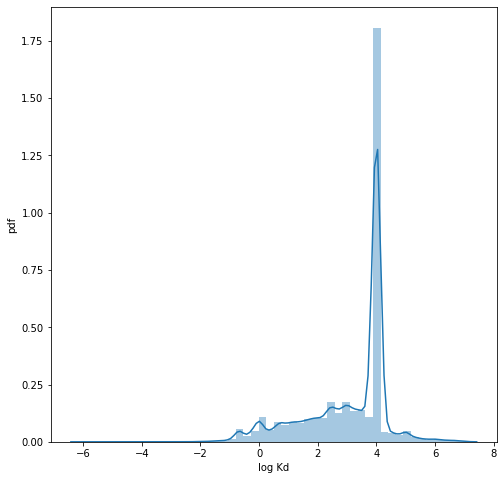

In [2]:
df = pd.read_csv('/home/sars-busters-consolidated/data/BindingDB_All.tsv', sep = '\t', error_bad_lines=False)
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1.0]
df = df[df['Ligand SMILES'].notnull()]

idx_str = 'Kd (nM)'

df_want = df[df[idx_str].notnull()]
df_want = df_want[['BindingDB Reactant_set_id', 'Ligand InChI', 'Ligand SMILES',\
                    'PubChem CID', 'UniProt (SwissProt) Primary ID of Target Chain',\
                    'BindingDB Target Chain  Sequence', idx_str]]

df_want.rename(columns={'BindingDB Reactant_set_id':'ID', 'Ligand SMILES':'SMILES',\
                        'Ligand InChI':'InChI', 'PubChem CID':'PubChem_ID',
                        'UniProt (SwissProt) Primary ID of Target Chain':'UniProt_ID',
                        'BindingDB Target Chain  Sequence': 'Target Sequence',
                            idx_str: 'Label'}, inplace=True)

df_want['Label'] = df_want['Label'].str.replace('>', '')
df_want['Label'] = df_want['Label'].str.replace('<', '')
df_want['Label'] = df_want['Label'].astype(float)

# have at least uniprot or pubchem ID
df_want = df_want[df_want.PubChem_ID.notnull() | df_want.UniProt_ID.notnull()]
df_want = df_want[df_want.InChI.notnull()]

df_want = df_want[(df_want.Label <= 10000000.0) & (df_want.Label != 0)]
#remove zeros
df_want=df_want[df_want['Label']>0]
print('There are ' + str(len(df_want)) + ' drug target pairs.')


kd_list = list(df_want.Label.values)
figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')

In [3]:
df_want_Kd = df_want[['SMILES','Target Sequence','Label']]

threshold = 30 ## DeepPurpose threshold in nM

df_want_Kd_binary = df_want_Kd.copy()
df_want_Kd_binary['Label'] = [1 if x < threshold else 0 for x in tqdm(df_want_Kd['Label'].tolist())]

ligands = list(set(df_want_Kd_binary['SMILES'].tolist()))
targets = list(set(df_want_Kd_binary['Target Sequence'].tolist()))

target_annotations_bindingDB = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations_bindingDB.append(len(sub_df))
    
print('Average annotations for proteins: ', np.mean(target_annotations_bindingDB))

100%|██████████| 1507/1507 [00:12<00:00, 116.01it/s]

Average annotations for proteins:  46.94492368944924


## Removing batch effect from BindingDB Kd

In [4]:
df_want_Kd_binary['Constant']=df_want_Kd['Label']
df_want_Kd_binary['Constant_log']=df_want_Kd_binary['Constant'].apply(np.log)
meanlog_constant=df_want_Kd_binary['Constant_log'].mean()
stdlog_constant=df_want_Kd_binary['Constant_log'].std()
df_want_Kd_binary=df_want_Kd_binary.sort_values(by=['Constant'])
print(df_want_Kd_binary['Constant_log'].mean())
print(df_want_Kd_binary['Constant_log'].std())

ecdfkr =ECDF(df_want_Kd_binary['Constant_log'])
MAT=np.array([ecdfkr.x, ecdfkr.y, norm.ppf(ecdfkr.y, loc=meanlog_constant, scale=stdlog_constant)]).T
MAT=MAT[1:,:]
MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=meanlog_constant, scale=stdlog_constant)
df_want_Kd_binary['Constant_lognormal']=MAT[:,2]
df_want_Kd_binary['Constant_transformed']=np.exp(df_want_Kd_binary['Constant_lognormal'])

7.104377155054556
3.3336849554043364


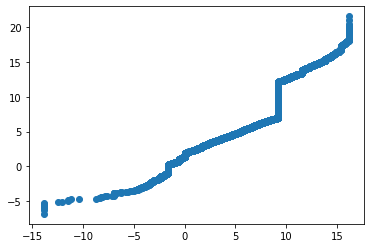

In [5]:
plt.scatter(df_want_Kd_binary['Constant_log'],df_want_Kd_binary['Constant_lognormal'] )

In [6]:
print(max(df_want_Kd_binary['Constant_log'][df_want_Kd_binary['Label']==1]))
print(max(df_want_Kd_binary['Constant_lognormal'][df_want_Kd_binary['Label']==1]))

Tlog=max(df_want_Kd_binary['Constant_lognormal'][df_want_Kd_binary['Label']==1])
df_want_Kd_binary['Labelcheck']=[1 if x < Tlog else 0 for x in tqdm(df_want_Kd_binary['Constant_lognormal'].tolist())]

100%|██████████| 70746/70746 [00:00<00:00, 1658693.03it/s]

3.3847291889548483
3.8093724849142


## Check Kd distribution after removing batch effect

100%|██████████| 1507/1507 [00:25<00:00, 58.24it/s]


[Text(0, 0.5, 'pdf'), Text(0.5, 0, 'log Kd')]

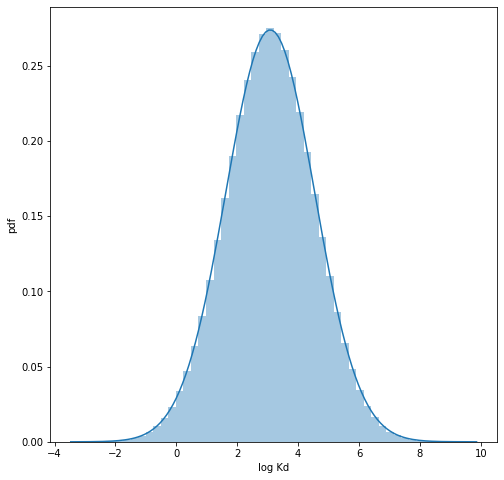

In [7]:
#tomonitor='Label'
tomonitor='Labelcheck'

#selectconstant='Constant'
selectconstant='Constant_transformed'


dictchem_kplus={}
dictchem_kminus={}
for chem in tqdm(ligands):
    dictchem_kplus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==1)
    dictchem_kminus[chem]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['SMILES']==chem]==0)
    
dictchem_k={chem:(dictchem_kplus[chem]+dictchem_kminus[chem]) for chem in ligands}
dictchem_ratio={chem:dictchem_kplus[chem]/dictchem_k[chem] for chem in ligands}

dicttarget_kplus={}
dicttarget_kminus={}
for t in tqdm(targets):
    dicttarget_kplus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==1)
    dicttarget_kminus[t]=sum(df_want_Kd_binary[tomonitor][df_want_Kd_binary['Target Sequence']==t]==0)
    
dicttarget_k={t:(dicttarget_kplus[t]+dicttarget_kminus[t]) for t in targets}
dicttarget_ratio={t:dicttarget_kplus[t]/dicttarget_k[t] for t in targets}

df_want_Kd_binary['k_l']=[dictchem_k[c] for c in df_want_Kd_binary['SMILES']]
df_want_Kd_binary['k_t']=[dicttarget_k[t] for t in df_want_Kd_binary['Target Sequence']]

kd_list = list(df_want_Kd_binary[selectconstant])
figure(figsize=(8, 8))
ax = sns.distplot(np.log10(kd_list), norm_hist=True)
ax.set(xlabel='log Kd', ylabel='pdf')

## Degree and associated Kd

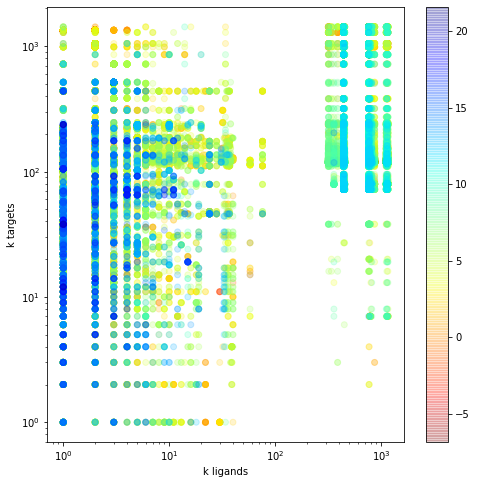

In [8]:
figure(figsize=(8, 8))
plt.scatter(df_want_Kd_binary['k_l'], df_want_Kd_binary['k_t'], c=df_want_Kd_binary[selectconstant].apply(np.log), alpha=0.2, cmap="jet_r")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k ligands')
plt.ylabel('k targets')
plt.colorbar()

## Degree ratio distributions

Text(0, 0.5, 'PDF')

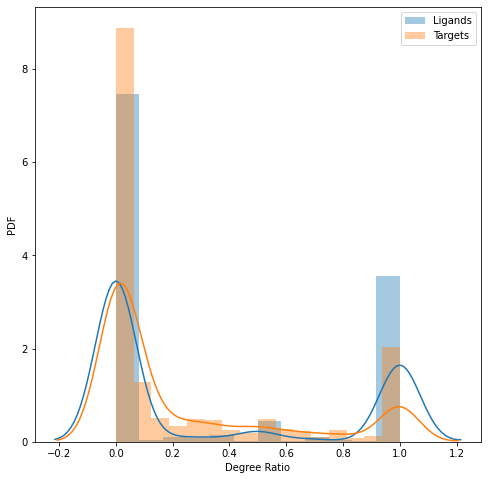

In [9]:
figure(figsize=(8, 8))
sns.distplot(list(dictchem_ratio.values()), label='Ligands')
sns.distplot(list(dicttarget_ratio.values()), label='Targets')
plt.legend()
plt.xlabel('Degree Ratio')
plt.ylabel('PDF')

# Analysing BindingDB DTI

In [10]:
B = nx.Graph()
B.add_nodes_from(ligands, bipartite=0)
B.add_nodes_from(targets, bipartite=1)
B.add_edges_from([(c,t) for c, t in df_want_Kd_binary[['SMILES', 'Target Sequence']].values])

In [11]:
nx.degree_assortativity_coefficient(B)

-0.2987859690737973

In [12]:
print(len(ligands))
print(len(targets))
print(max([B.degree(l) for l  in ligands]))
print(max([B.degree(t) for t in targets]))

13390
1507
397
1121


In [13]:
print('Number of proteins/nodes: ', len(targets))
target_annotations = []
target_average_Kd = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_average_Kd.append(np.mean(sub_df[selectconstant].tolist()))
    
different_target_annotations = list(set(target_annotations))
unique_Kd_targets = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(target_average_Kd[j])
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    
print('Proteins - Correlation between node k and Kd: ', stats.spearmanr(target_annotations,target_average_Kd))
print('Proteins - Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations,unique_Kd_targets))

  1%|          | 12/1507 [00:00<00:12, 116.22it/s]

Number of proteins/nodes:  1507


100%|██████████| 172/172 [00:00<00:00, 6918.90it/s]

Proteins - Correlation between node k and Kd:  SpearmanrResult(correlation=0.3399545931879757, pvalue=4.4063759957873965e-42)
Proteins - Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.5421922867391626, pvalue=1.569980027727399e-14)


In [14]:
# log space
selectconstant_log='Constant_lognormal'
print('Number of proteins/nodes: ', len(targets))
target_annotations = []
target_average_Kd = []
target_std_Kd = []

for prot in tqdm(targets):
    sub_df = df_want_Kd_binary[df_want_Kd_binary['Target Sequence'] == prot]
    target_annotations.append(len(sub_df))
    target_average_Kd.append(np.mean(sub_df[selectconstant_log].tolist()))
    target_std_Kd.append(np.std(sub_df[selectconstant_log].tolist()))
    
different_target_annotations = list(set(target_annotations))
unique_Kd_targets = []
unique_std_Kd_targets = []

for unique_ann in tqdm(different_target_annotations):
    
    all_Kd_list = []    
    all_indices = get_all_indices(target_annotations,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(target_average_Kd[j])
        
    unique_Kd_targets.append(np.mean(all_Kd_list))
    unique_std_Kd_targets.append(np.std(all_Kd_list))

  1%|          | 12/1507 [00:00<00:13, 113.79it/s]

Number of proteins/nodes:  1507


100%|██████████| 172/172 [00:00<00:00, 5704.55it/s]


In [15]:
# log space
print('Proteins - Correlation between node k and Kd: ', stats.spearmanr(target_annotations,target_average_Kd))
print('Proteins - Correlation between node k and Kd std: ', stats.spearmanr(target_annotations,target_std_Kd))
print('Proteins - Correlation between k and <Kd>: ', stats.spearmanr(different_target_annotations,unique_Kd_targets))
print('Proteins - Correlation between k and <Kd> std: ', stats.spearmanr(different_target_annotations,unique_std_Kd_targets))

Proteins - Correlation between node k and Kd:  SpearmanrResult(correlation=0.2978643834993303, pvalue=2.9719005190827526e-32)
Proteins - Correlation between node k and Kd std:  SpearmanrResult(correlation=0.6653239144750266, pvalue=2.802608719918172e-193)
Proteins - Correlation between k and <Kd>:  SpearmanrResult(correlation=0.0027215504819314046, pvalue=0.9717347917051469)
Proteins - Correlation between k and <Kd> std:  SpearmanrResult(correlation=-0.7150037469560117, pvalue=3.186000265383969e-28)


Mean and standard deviation of log Kd:  7.104581746618654 3.333633341053326


Text(0, 0.5, 'Average $K_d$')

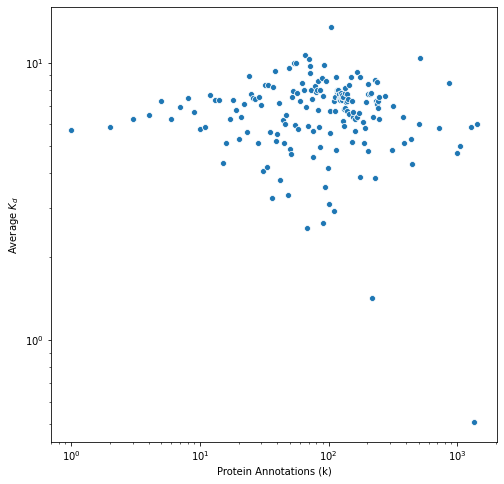

In [16]:
# this values are per link
mean_log_Kd = np.mean(np.log(kd_list))
std_log_Kd = np.std(np.log(kd_list))

#mean_log_Kd = np.mean(np.log(target_average_Kd))
#std_log_Kd = np.std(np.log(target_average_Kd))
print('Mean and standard deviation of log Kd: ', mean_log_Kd, std_log_Kd)

figure(figsize=(8, 8))
sns.scatterplot(different_target_annotations,unique_Kd_targets)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Protein Annotations (k)')
plt.ylabel(r'Average $K_d$')

Proteins - Correlation between node k and ratio:  SpearmanrResult(correlation=0.12297376446051768, pvalue=1.6838804447078744e-06)


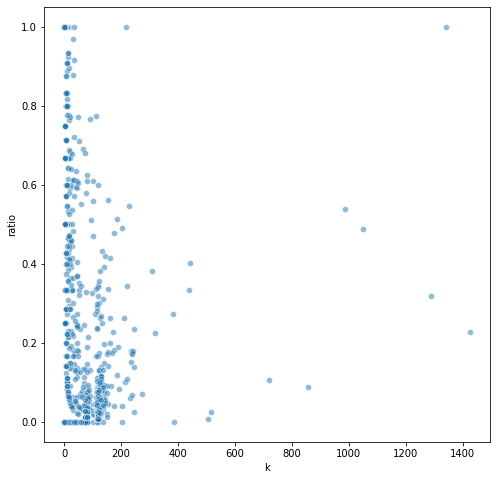

<Figure size 576x576 with 0 Axes>

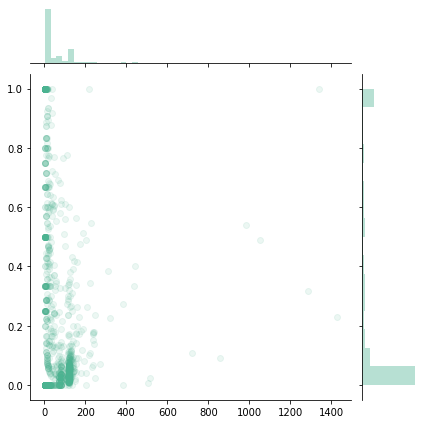

In [17]:
# targets
figure(figsize=(8, 8))
x=[dicttarget_k[t] for t in targets]
y=[dicttarget_ratio[t] for t in targets]
sns.scatterplot(x, y, alpha=0.5)
plt.xlabel('k')
plt.ylabel('ratio')


print('Proteins - Correlation between node k and ratio: ', stats.spearmanr(x,y))



figure(figsize=(8, 8))
sns.jointplot(x=[dicttarget_k[t] for t in targets],y=[dicttarget_ratio[t] for t in targets],
              color="#4CB391",
             alpha=0.1)
#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel('Protein Annotations (k)')
#plt.ylabel(r'Average $K_d$')

100%|██████████| 172/172 [00:00<00:00, 6807.07it/s]

Proteins - Correlation between node k and ratio:  SpearmanrResult(correlation=0.12297376446051768, pvalue=1.6838804447078744e-06)
Proteins - Correlation between k and <ratio>:  SpearmanrResult(correlation=-0.15479857177264986, pvalue=0.042601174923062576)


Text(0, 0.5, 'Average ratio')

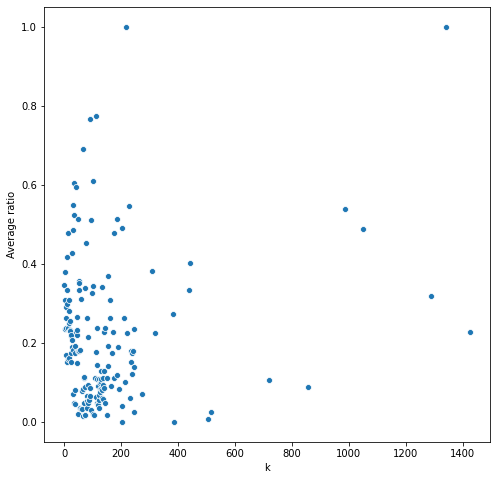

In [18]:
different_x = sorted(list(set(x)))
unique_y= []

for unique_ann in tqdm(different_x):
    
    yperx = []    
    all_indices = get_all_indices(x,unique_ann)
    
    for j in all_indices:
        yperx.append(y[j])
        
    unique_y.append(np.mean(yperx))
    
print('Proteins - Correlation between node k and ratio: ', stats.spearmanr(x, y))
print('Proteins - Correlation between k and <ratio>: ', stats.spearmanr(different_x,unique_y))


figure(figsize=(8, 8))
sns.scatterplot(different_x,unique_y)
plt.xlabel('k')
plt.ylabel('Average ratio')

In [19]:
# node with degree 1
yperx = []    
all_indices = get_all_indices(x,1)
    
for j in all_indices:
        yperx.append(y[j])
 

print(set(yperx))
print(sum(np.array(yperx)==0))
print(sum(np.array(yperx)==1))

{0.0, 1.0}
206
109


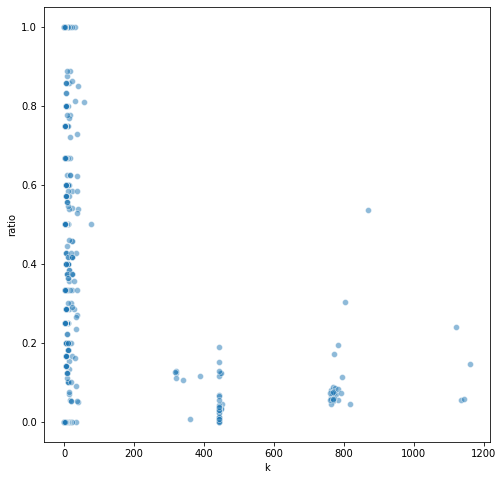

<Figure size 576x576 with 0 Axes>

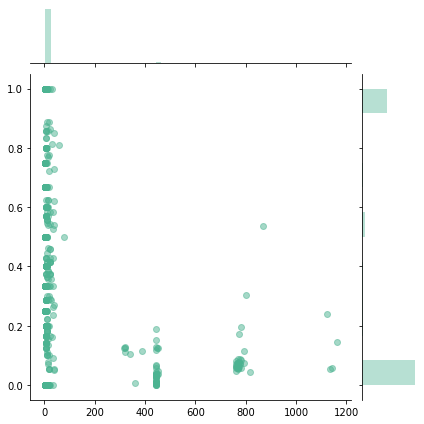

In [20]:
# ligands

figure(figsize=(8, 8))
sns.scatterplot([dictchem_k[c] for c in ligands],[dictchem_ratio[c] for c in ligands], alpha=0.5)
plt.xlabel('k')
plt.ylabel('ratio')
figure(figsize=(8, 8))
sns.jointplot(x=[dictchem_k[c] for c in ligands],y=[dictchem_ratio[c] for c in ligands],
              color="#4CB391",
             alpha=0.5)

# Power-Law + Correlation

In [21]:
std_log_Kd_original = std_log_Kd

In [22]:
print(mean_log_Kd)
print(std_log_Kd)

7.104581746618654
3.333633341053326


In [23]:
THR = 0.5 # p_bind threshold
anti_corr = -0.5 
std_log_Kd = std_log_Kd_original

In [24]:
simulated_network_nodes=len(target_annotations)

K_from_copula_list = sorted(target_annotations)

while (sum(K_from_copula_list) % 2 != 0): ## Make the degree sequence graphical
    print('Degree Sequence Non Graphical')
    non_1_degrees = []
    for x in K_from_copula_list:
        if x > 1:
            non_1_degrees.append(x)
    random_non_1_entry = np.random.choice(non_1_degrees) ## Choosing a node at random who's degree is not 1
    j = K_from_copula_list.index(random_non_1_entry)
    K_from_copula_list[j] = K_from_copula_list[j] - 1
    print(sum(K_from_copula_list) % 2 == 0)

G = nx.configuration_model(K_from_copula_list, create_using=nx.Graph(), seed=None)
G.remove_edges_from(nx.selfloop_edges(G))
degrees_from_network = [G.degree(node) for node in list(G.nodes())]

print('Max degree in degree sequence: ', max(K_from_copula_list))
print('Max degree in network: ', max(degrees_from_network))

print('Mean degree in degree sequence: ', np.mean(K_from_copula_list))
print('Mean degree in network: ', np.mean(degrees_from_network))

Max degree in degree sequence:  1426
Max degree in network:  552
Mean degree in degree sequence:  46.94492368944924
Mean degree in network:  38.10484406104844


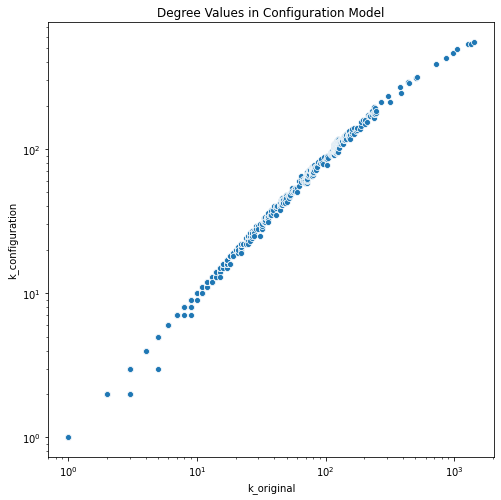

In [25]:
figure(figsize=(8, 8))
ax = sns.scatterplot(K_from_copula_list, degrees_from_network)
ax.set(title='Degree Values in Configuration Model',xscale='log',yscale='log',xlabel='k_original',ylabel='k_configuration')
plt.show()

## Without fluctuations

In [26]:
ecdfK =ECDF(degrees_from_network)
MAT=np.array([ecdfK.x, ecdfK.y, norm.ppf(ecdfK.y, loc=0, scale=1)]).T
MAT=MAT[1:,:]
#MAT[:,2][np.isinf(MAT[:,2])]=6
MAT[-1,2]=norm.ppf((MAT.shape[0]-0.5)/MAT.shape[0], loc=0, scale=1)
# in the Pearson version (make it stronger to get a value for Speraman comparable)
expMU=mean_log_Kd+anti_corr*std_log_Kd*MAT[:,2]
expSIGMA=np.sqrt((1-anti_corr**2)*(std_log_Kd**2))

MAT=np.append(MAT,norm.rvs(loc=expMU, scale=expSIGMA).reshape(len(norm.rvs(loc=expMU, scale=expSIGMA)),1), axis=1)
MAT=np.append(MAT,np.exp(MAT[:,3].reshape(MAT.shape[0],1)), axis=1)

print('Obtained Spearman', stats.spearmanr(MAT[:,1],MAT[:,3]))
print('Obtained avg log K', np.mean(MAT[:,3]))
print('Obtained std log K', np.std(MAT[:,3]))

Obtained Spearman SpearmanrResult(correlation=-0.48938635457799184, pvalue=1.4129516620797823e-91)
Obtained avg log K 7.08700289609585
Obtained std log K 3.372074254383838


In [27]:
## Check correlation between k and Kd
K_from_copula_list=list(MAT[:,0].astype(int))
Kd_from_copula_list=list(MAT[:,4])
## Checks on original Kd distribution and Kd from copula

print(np.mean(np.log(Kd_from_copula_list)))
print(mean_log_Kd)
print(np.std(np.log(Kd_from_copula_list)))
print(std_log_Kd)

## Correlation between k and Kd obtained from copula 

print('Correlation between k and Kd obtained from copula: ', stats.spearmanr(K_from_copula_list,Kd_from_copula_list))

print(sum(K_from_copula_list) % 2 == 0) ## True if graphical

## Making the degree sequence graphical

while (sum(K_from_copula_list) % 2 != 0) :
    non_1_degrees = []
    for x in K_from_copula_list:
        if x > 1:
            non_1_degrees.append(x)
    random_non_1_entry = np.random.choice(non_1_degrees) ## Choosing a node at random who's degree is not 1
    j = K_from_copula_list.index(random_non_1_entry)
    K_from_copula_list[j] = K_from_copula_list[j] - 1
    print(sum(K_from_copula_list) % 2 == 0)

## Check correlation between k and Kd

different_target_annotations_copula = list(set(K_from_copula_list))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(K_from_copula_list,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(Kd_from_copula_list[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))


100%|██████████| 159/159 [00:00<00:00, 4927.11it/s]

7.08700289609585
7.104581746618654
3.372074254383838
3.333633341053326
Correlation between k and Kd obtained from copula:  SpearmanrResult(correlation=-0.4826718684844818, pvalue=8.889738736243114e-89)
True
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.7085413183663721, pvalue=1.5158613049700645e-25)


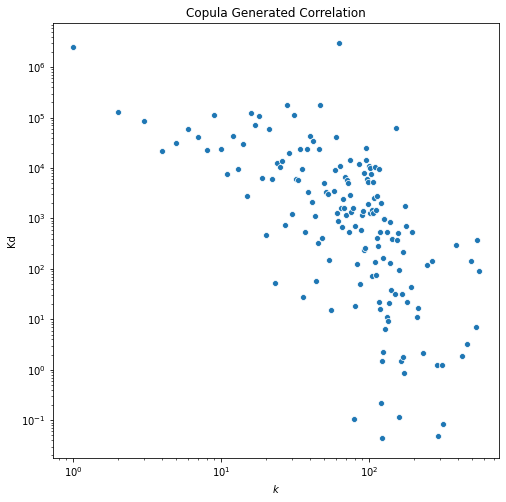

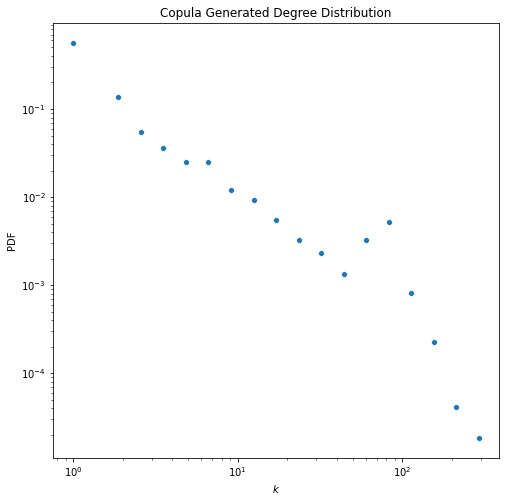

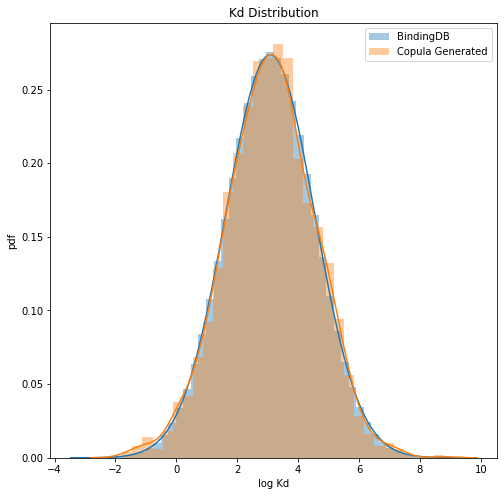

In [28]:
figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula,palette="#E8718C")
ax.set(title='Copula Generated Correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(degrees_from_network,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann,palette="#E8718C")
ax.set(title='Copula Generated Degree Distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
ax = sns.distplot(np.log10(Kd_from_copula_list), label='Copula Generated', norm_hist=True)
ax.set(title='Kd Distribution',xlabel='log Kd', ylabel='pdf')
plt.legend()
plt.show()

100%|██████████| 28712/28712 [00:00<00:00, 759575.24it/s]


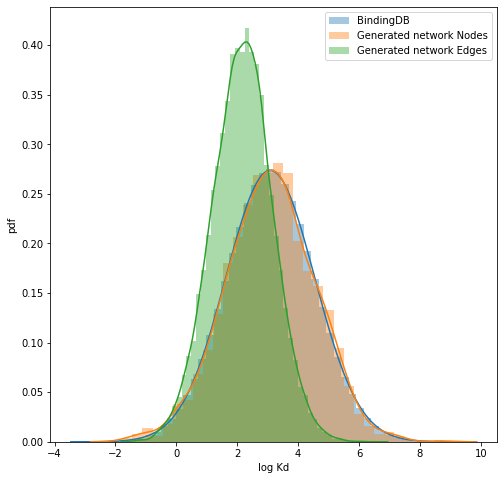

Threshold:  144.26536423072426


In [29]:
node_Kd_values = dict(zip(range(len(K_from_copula_list)), Kd_from_copula_list))
network_data = generate_network(G, node_Kd_values, kd_list, p_bind = THR)

## With fluctuations

100%|██████████| 159/159 [00:12<00:00, 13.18it/s]


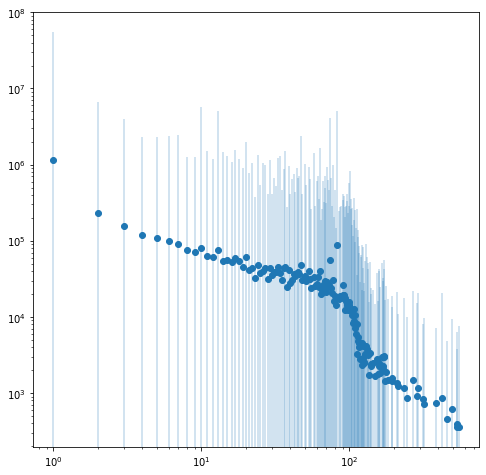

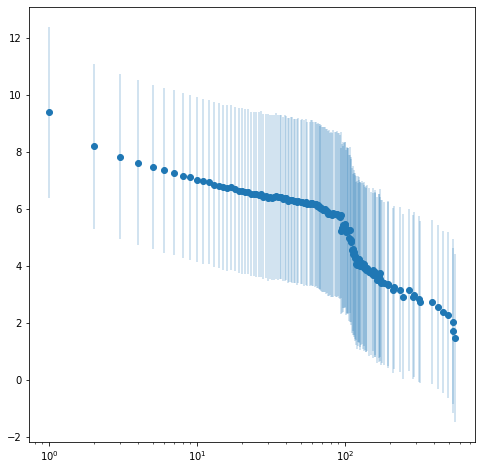

100%|██████████| 1507/1507 [00:01<00:00, 931.05it/s]


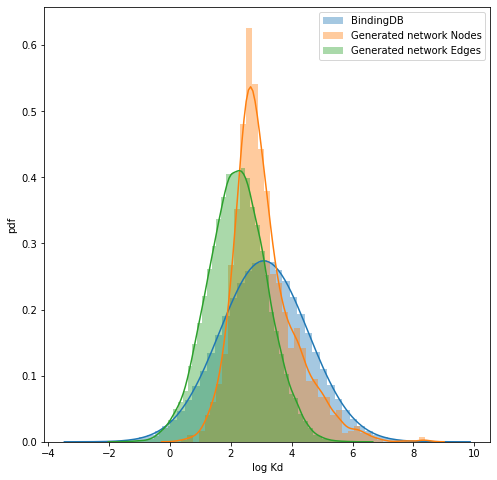

Threshold:  164.80072240657947


In [31]:
network_data_BC, degrees_from_network, node_Kd_values_avg_sampled, MATsample = sampling_with_corr(G, anti_corr, mean_log_Kd, std_log_Kd,kd_list, p_bind = THR)

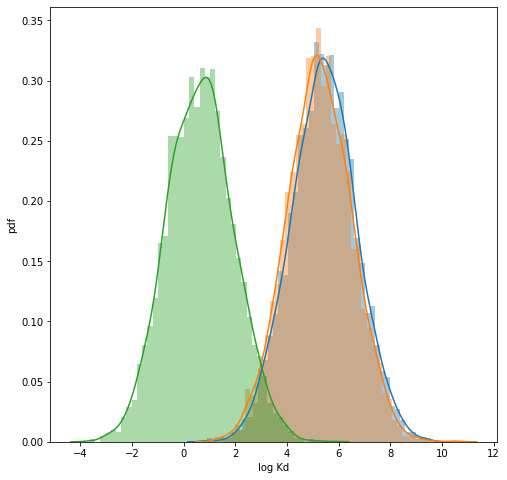

In [32]:
figure(figsize=(8, 8))
ax = sns.distplot(np.log10(MATsample[0,:]))
ax = sns.distplot(np.log10(MATsample[1,:]))
ax = sns.distplot(np.log10(MATsample[-1,:]))
ax.set(xlabel='log Kd', ylabel='pdf')
plt.show()

100%|██████████| 159/159 [00:00<00:00, 6888.83it/s]

mean log Kd from copula  7.111631270392633
mean log Kd original  7.104581746618654
std log Kd from copula  2.325046444543112
std log Kd original  3.333633341053326
Correlation between node copula generated k and Kd:  SpearmanrResult(correlation=-0.7326882188720437, pvalue=8.244609717486663e-254)
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.9799349176021018, pvalue=6.929465212117594e-112)


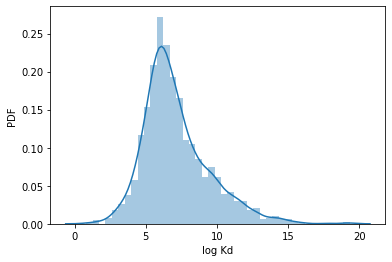

In [33]:
sns.distplot(np.log(node_Kd_values_avg_sampled))
plt.xlabel('log Kd')
plt.ylabel('PDF')

## Checks on original Kd duistribution and Kd from copula

print('mean log Kd from copula ', np.mean(np.log(node_Kd_values_avg_sampled)))
print('mean log Kd original ', mean_log_Kd)
print('std log Kd from copula ',np.std(np.log(node_Kd_values_avg_sampled)))
print('std log Kd original ',std_log_Kd)

print('Correlation between node copula generated k and Kd: ', stats.spearmanr(degrees_from_network,node_Kd_values_avg_sampled))

different_target_annotations_copula = list(set(degrees_from_network))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(degrees_from_network,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(node_Kd_values_avg_sampled[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))

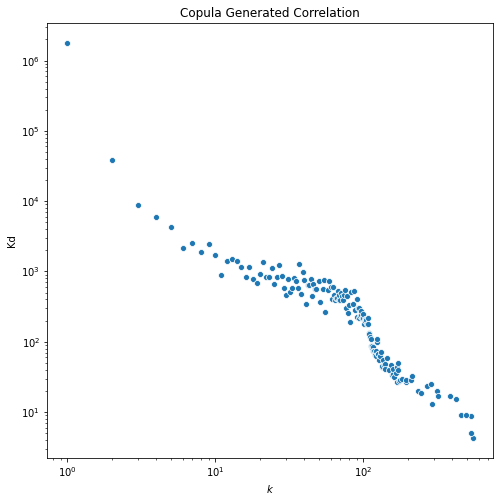

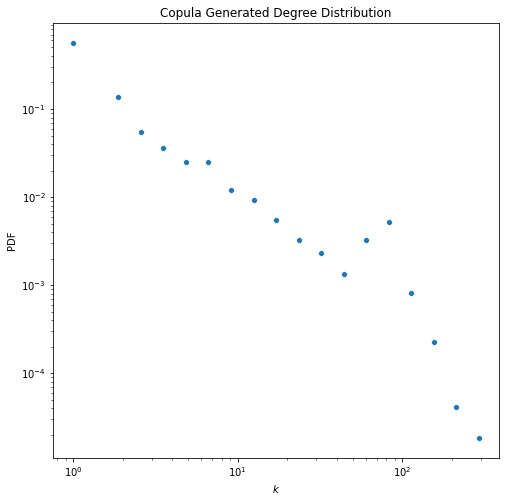

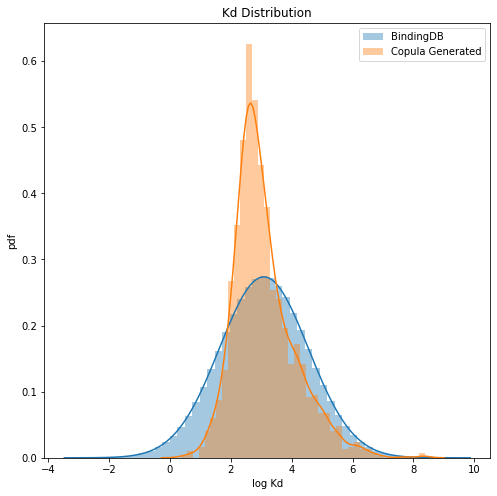

In [34]:
figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
ax.set(title='Copula Generated Correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(degrees_from_network,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
ax.set(title='Copula Generated Degree Distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
ax = sns.distplot(np.log10(node_Kd_values_avg_sampled), label='Copula Generated', norm_hist=True)
ax.set(title='Kd Distribution',xlabel='log Kd', ylabel='pdf')
plt.legend()
plt.show()

## Configuration model without fluctuations

100%|██████████| 1399/1399 [00:02<00:00, 480.21it/s]


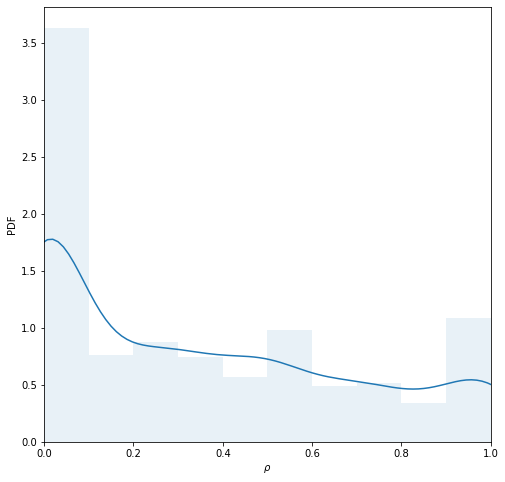

  0%|          | 2/10000 [00:00<11:00, 15.14it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.4937656728893842


  0%|          | 49/10000 [00:03<11:14, 14.75it/s]
90it [00:00, 899.00it/s]

Loops  50
Error margin:  [9.26605882e-06]


8614it [00:09, 933.12it/s]


AUC:  0.9696277757431997
AUP:  0.9583615912548015
Transductive performance:
AUC:  0.9728060756709204
AUP:  0.9623928029988339


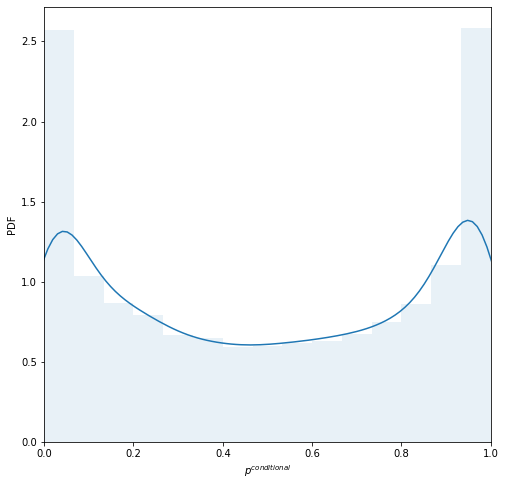

In [35]:
run_configuration_model(network_data)

100%|██████████| 1394/1394 [00:02<00:00, 480.16it/s]


Number of zero positive degree  462
Mean positive degree  14.245337159253946
Std positive degree  27.190835429286917
%%%%%%%
Mean negative degree  14.589670014347202
Std negative degree  21.586489664743066
%%%%%%%
Mean degree  28.83500717360115
Std degree  40.18043996581463


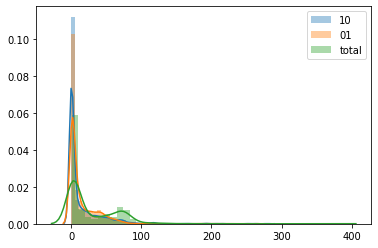

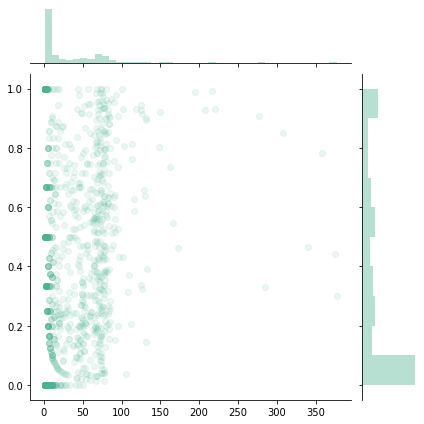

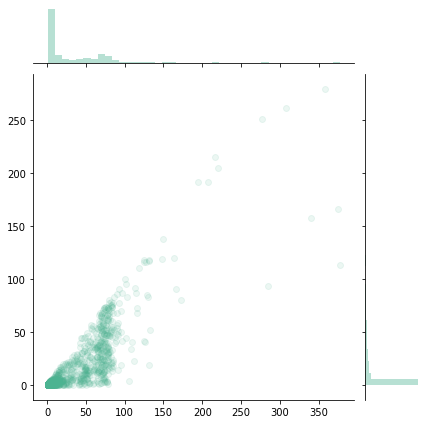

In [36]:
train, test = train_test_split(network_data, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              color="#4CB391",
             alpha=0.1)


sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              color="#4CB391",
             alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## Configuration model with fluctuations

100%|██████████| 1388/1388 [00:02<00:00, 487.15it/s]


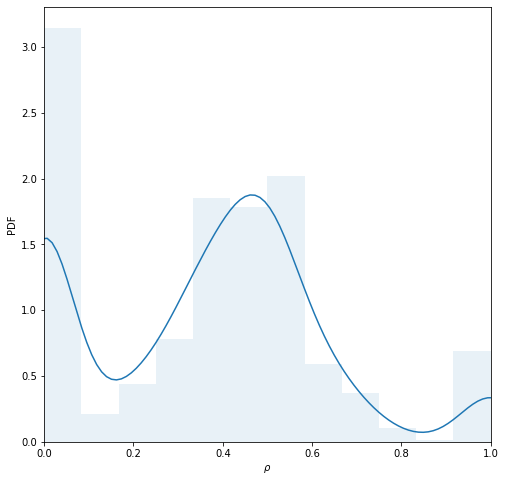

  0%|          | 2/10000 [00:00<10:56, 15.23it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.49916411256617443


  1%|          | 59/10000 [00:03<10:50, 15.29it/s]
87it [00:00, 865.64it/s]

Loops  60
Error margin:  [9.1952071e-06]


8614it [00:09, 939.15it/s]


AUC:  0.6366796396713448
AUP:  0.6265513515036456
Transductive performance:
AUC:  0.6379554268418212
AUP:  0.6310138148515101


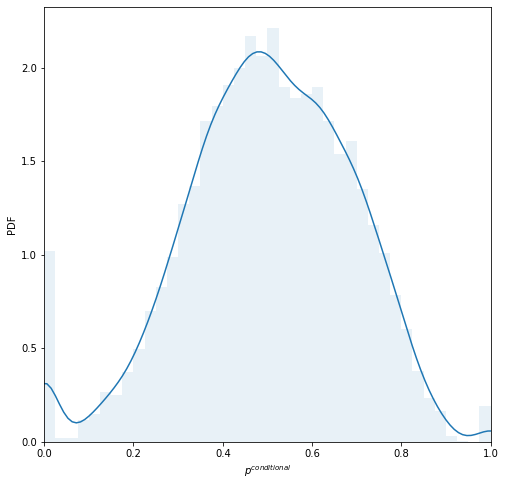

In [37]:
run_configuration_model(network_data_BC)

100%|██████████| 1404/1404 [00:02<00:00, 486.22it/s]


Number of zero positive degree  378
Mean positive degree  14.286324786324787
Std positive degree  25.44186291306331
%%%%%%%
Mean negative degree  14.343304843304843
Std negative degree  16.43233832794848
%%%%%%%
Mean degree  28.62962962962963
Std degree  40.294653765543735


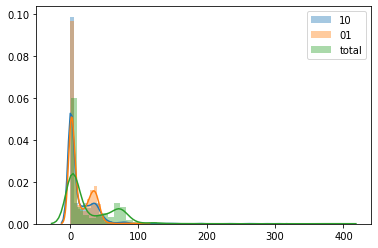

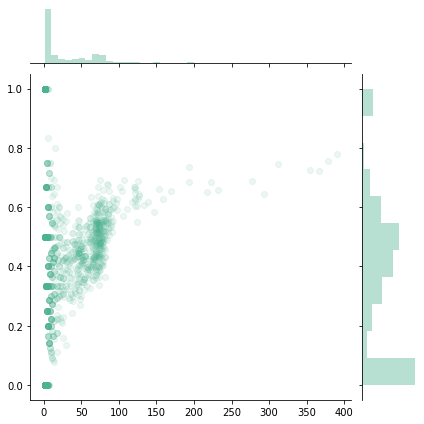

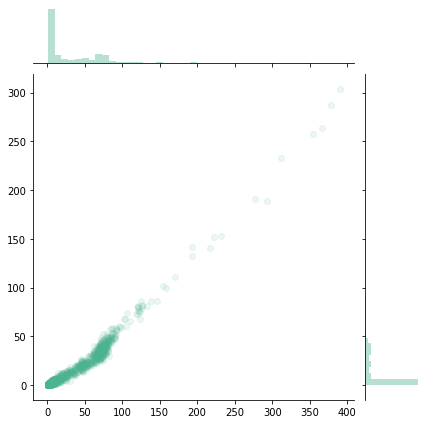

In [38]:
train, test = train_test_split(network_data_BC, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              color="#4CB391",
             alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              color="#4CB391",
             alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## Other checks

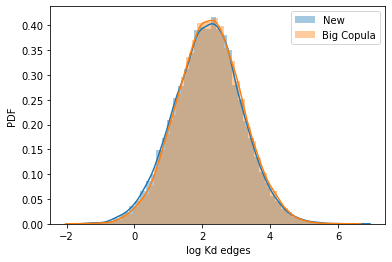

In [39]:
sns.distplot(np.log10(network_data['edge_Kd']), label='New')
sns.distplot(np.log10(network_data_BC['edge_Kd']), label='Big Copula')
plt.xlabel('log Kd edges')
plt.ylabel('PDF')
plt.legend()

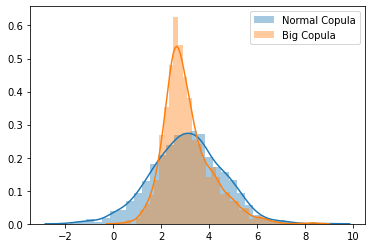

In [40]:
sns.distplot(np.log10(Kd_from_copula_list), label='Normal Copula')
sns.distplot(np.log10(node_Kd_values_avg_sampled), label='Big Copula')
plt.legend()

# Power-Law + No Correlation

## Without fluctuations 

  3%|▎         | 46/1390 [00:00<00:02, 454.00it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=0.12654048244566515, pvalue=0.11196537834384164)


100%|██████████| 1390/1390 [00:02<00:00, 485.20it/s]


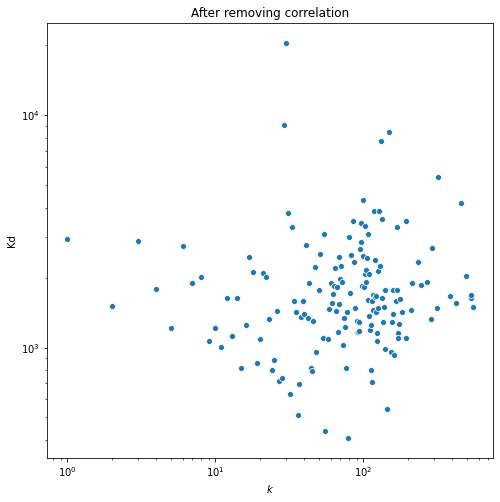

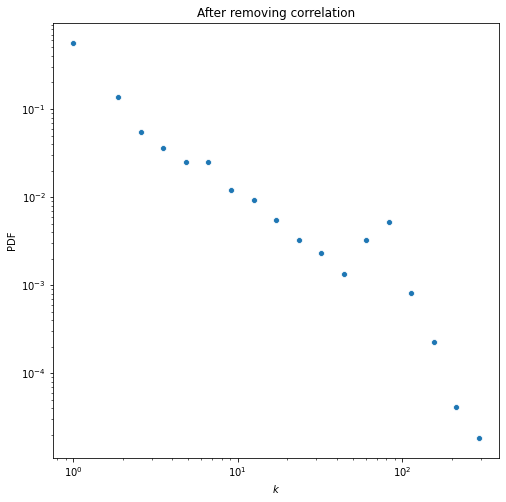

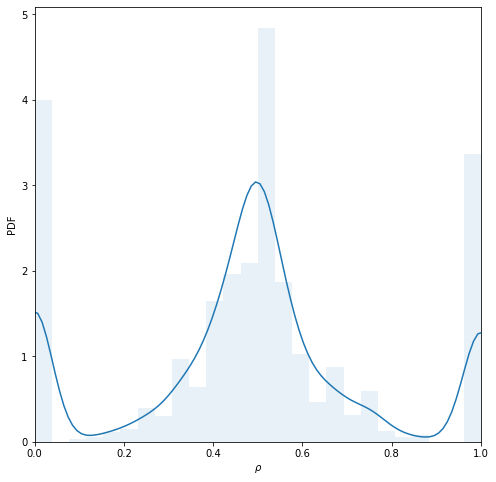

  0%|          | 2/10000 [00:00<11:04, 15.04it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.4937656728893842


  1%|          | 68/10000 [00:04<10:57, 15.12it/s]
99it [00:00, 980.03it/s]

Loops  69
Error margin:  [8.02316494e-06]


8614it [00:09, 946.17it/s]


AUC:  0.5063479125291379
AUP:  0.5036233323943485
Transductive performance:
AUC:  0.5060345490646602
AUP:  0.5035520113839689


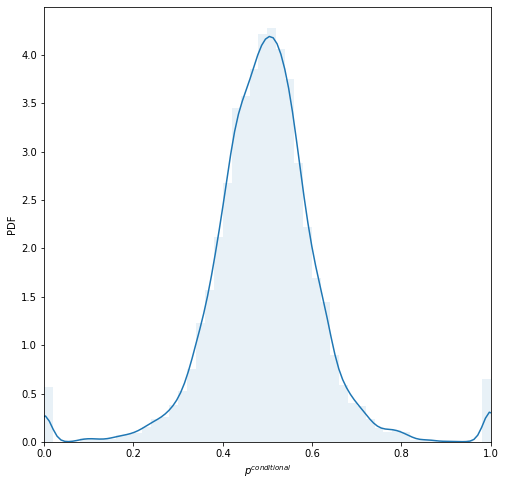

In [41]:
network_data_shuffled = remove_correlation_run_configuration_model(network_data, precision=10**(-5), loops=10000)

100%|██████████| 1401/1401 [00:02<00:00, 487.46it/s]


Number of zero positive degree  219
Mean positive degree  14.182726623840114
Std positive degree  19.95003076003663
%%%%%%%
Mean negative degree  14.508208422555319
Std negative degree  20.59791739476416
%%%%%%%
Mean degree  28.69093504639543
Std degree  40.19196597709889


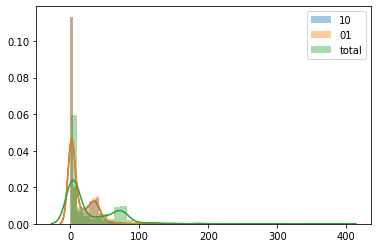

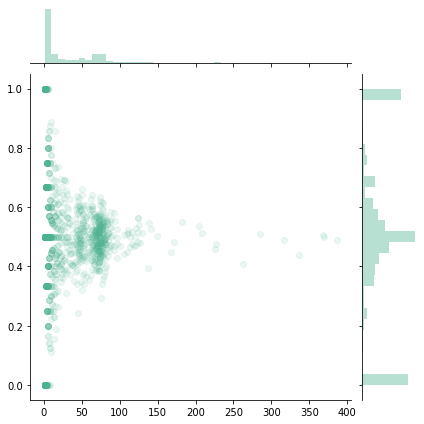

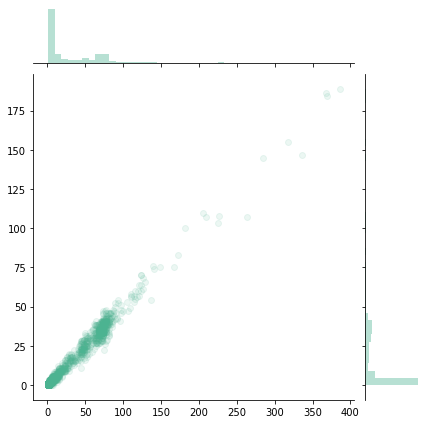

In [42]:
train, test = train_test_split(network_data_shuffled, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()

sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              color="#4CB391",
             alpha=0.1)


sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              color="#4CB391",
             alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## With fluctuations 

  3%|▎         | 43/1406 [00:00<00:03, 426.46it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.006200740386911871, pvalue=0.9381683716669578)


100%|██████████| 1406/1406 [00:02<00:00, 490.63it/s]


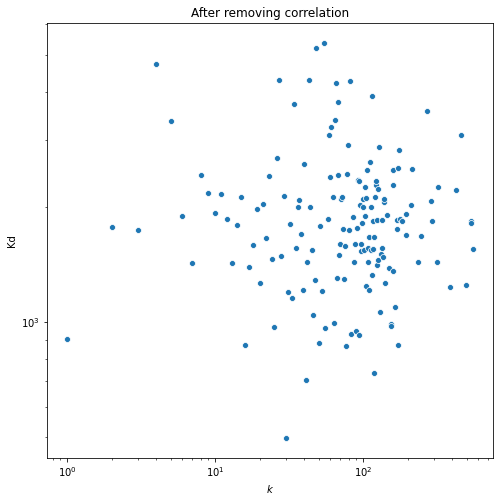

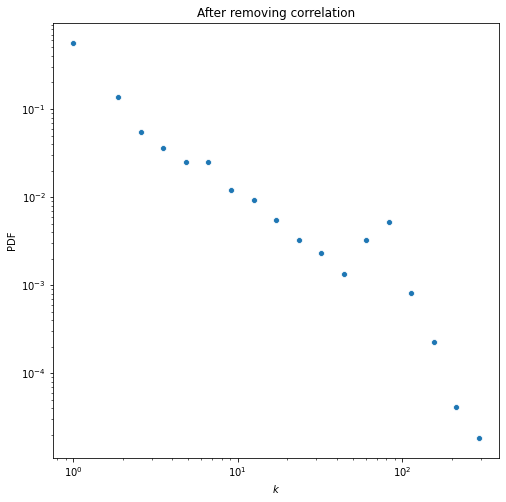

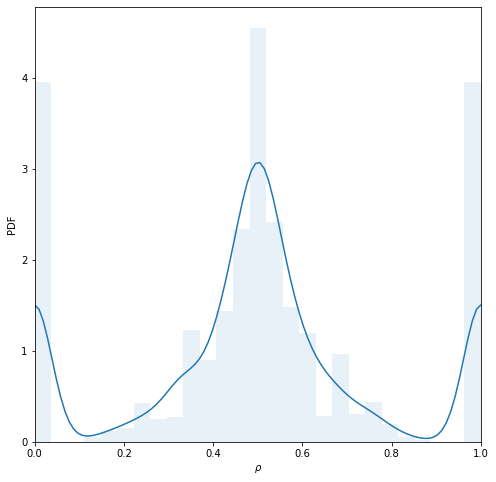

  0%|          | 2/10000 [00:00<11:21, 14.68it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.49916411256617443


  1%|          | 68/10000 [00:04<11:24, 14.52it/s]
97it [00:00, 965.38it/s]

Loops  69
Error margin:  [8.73660273e-06]


8614it [00:09, 938.07it/s]


AUC:  0.4934662303559774
AUP:  0.4866295966804034
Transductive performance:
AUC:  0.49312632224248665
AUP:  0.486893661681282


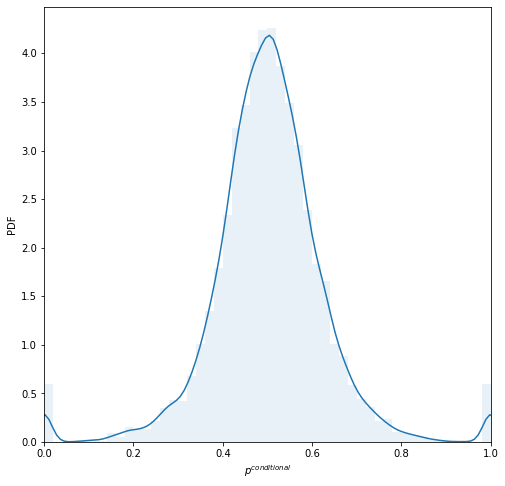

In [43]:
network_data_BC_shuffled = remove_correlation_run_configuration_model(network_data_BC, precision=10**(-5), loops=10000)

100%|██████████| 1402/1402 [00:02<00:00, 489.72it/s]


Number of zero positive degree  206
Mean positive degree  14.356633380884452
Std positive degree  20.361527092227192
%%%%%%%
Mean negative degree  14.313837375178316
Std negative degree  20.387996656639125
%%%%%%%
Mean degree  28.670470756062766
Std degree  40.351891504553066


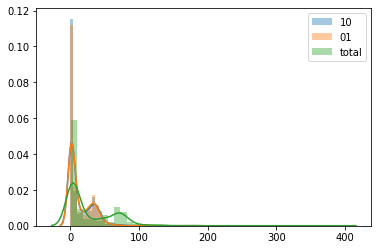

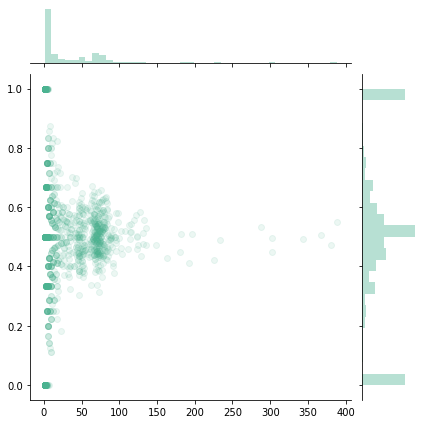

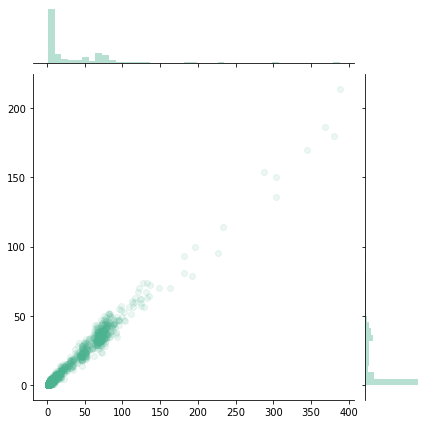

In [44]:
train, test = train_test_split(network_data_BC_shuffled, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()

sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              color="#4CB391",
             alpha=0.1)


sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              color="#4CB391",
             alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

100%|██████████| 159/159 [00:00<00:00, 3859.30it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=-0.006200740386911871, pvalue=0.9381683716669578)


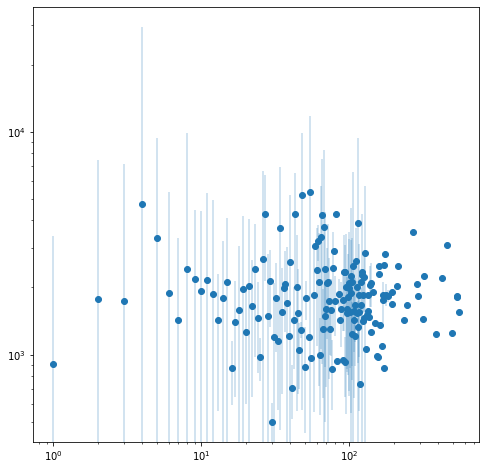

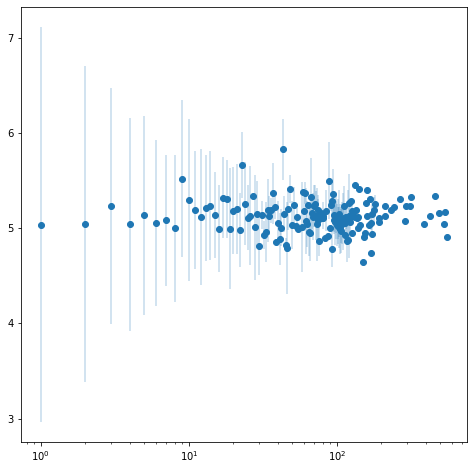

In [45]:
plot_k_Kd_relation(network_data_BC_shuffled)

# Poisson + Correlation

In [46]:
K_from_copula_listP=list(poisson.rvs(np.mean(degrees_from_network), size=simulated_network_nodes))

while (sum(K_from_copula_listP) % 2 != 0):
    print('Degree Sequence Non Graphical')
    non_1_degrees = []
    for x in K_from_copula_listP:
        if x > 1:
            non_1_degrees.append(x)
    random_non_1_entry = np.random.choice(non_1_degrees) ## Choosing a node at random who's degree is not 1
    j = K_from_copula_listP.index(random_non_1_entry)
    K_from_copula_listP[j] = K_from_copula_listP[j] - 1
    print(sum(K_from_copula_listP) % 2 == 0)

GP = nx.configuration_model(K_from_copula_listP, create_using=nx.Graph(), seed=None)
GP.remove_edges_from(nx.selfloop_edges(GP))
degrees_from_networkP = [GP.degree(node) for node in list(G.nodes())]

print('Max degree in degree sequence: ', max(K_from_copula_listP))
print('Max degree in network: ', max(degrees_from_networkP))

print('Mean degree in degree sequence: ', np.mean(K_from_copula_listP))
print('Mean degree in network: ', np.mean(degrees_from_networkP))

Degree Sequence Non Graphical
True
Max degree in degree sequence:  60
Max degree in network:  57
Mean degree in degree sequence:  38.17120106171201
Mean degree in network:  37.60451227604512


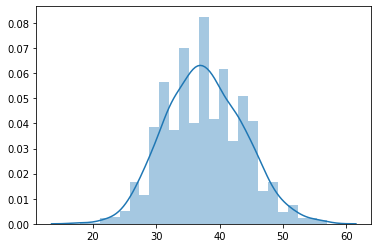

In [47]:
sns.distplot(degrees_from_networkP)

100%|██████████| 28335/28335 [00:00<00:00, 754426.77it/s]


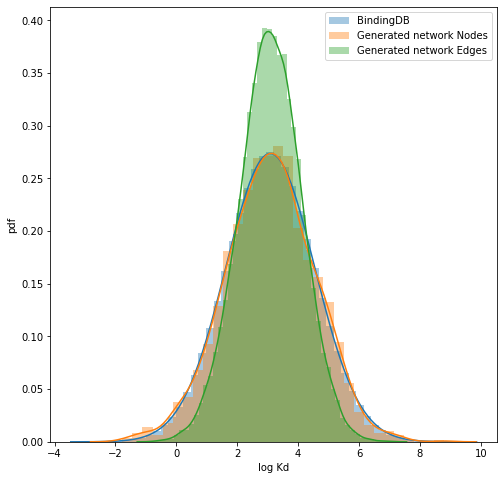

Threshold:  1197.3684407067033


In [48]:
node_Kd_valuesP = dict(zip(range(len(K_from_copula_listP)), Kd_from_copula_list))
network_dataP = generate_network(GP, node_Kd_valuesP, kd_list, p_bind = THR)

## Without fluctuation 

100%|██████████| 1507/1507 [00:03<00:00, 489.78it/s]


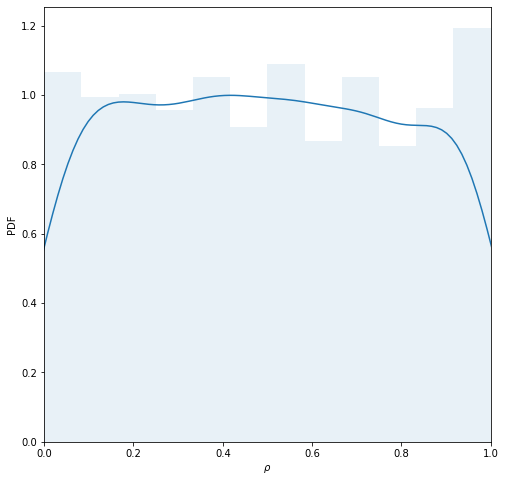

  0%|          | 2/10000 [00:00<14:32, 11.46it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.49631198164813833


  4%|▎         | 352/10000 [00:26<12:15, 13.12it/s]
118it [00:00, 1175.01it/s]

Loops  353
Error margin:  [9.72815182e-06]


8501it [00:06, 1347.30it/s]


AUC:  0.9739304675928341
AUP:  0.9716757855281415
Transductive performance:
AUC:  0.9739304675928341
AUP:  0.9716757855281415


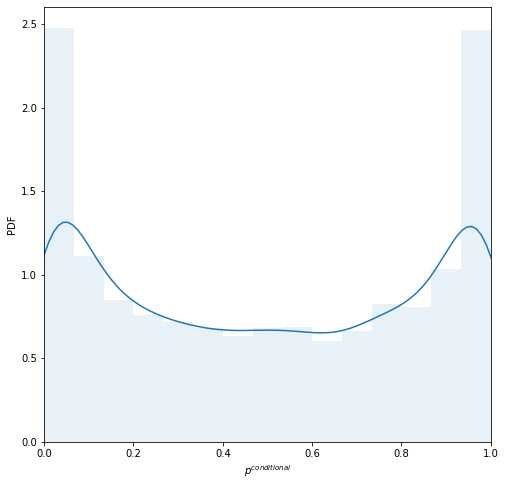

In [49]:
run_configuration_model(network_dataP, precision=10**(-5), loops=10000)

100%|██████████| 1507/1507 [00:03<00:00, 452.57it/s]


Number of zero positive degree  52
Mean positive degree  13.048440610484406
Std positive degree  8.334395749657013
%%%%%%%
Mean negative degree  13.274054412740544
Std negative degree  8.334967058382729
%%%%%%%
Mean degree  26.32249502322495
Std degree  5.063581631358752


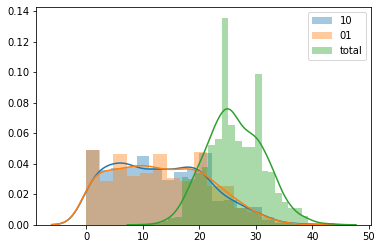

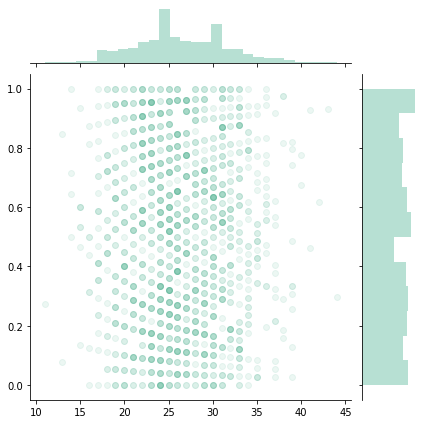

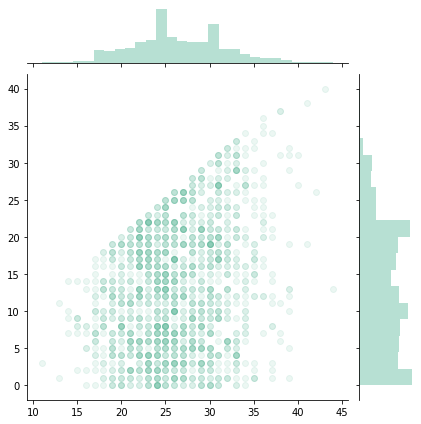

In [50]:
train, test = train_test_split(network_dataP, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()

sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              color="#4CB391",
             alpha=0.1)


sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              color="#4CB391",
             alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## With fluctuations 

100%|██████████| 38/38 [00:07<00:00,  4.95it/s]


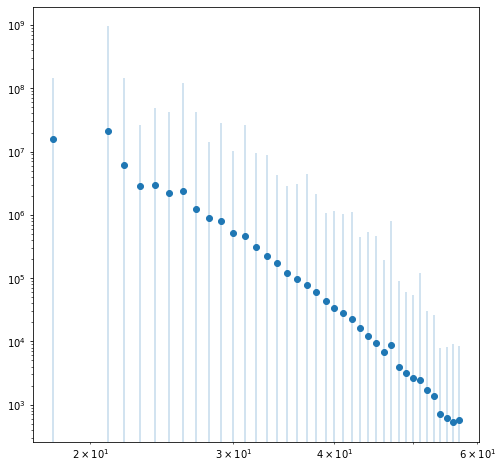

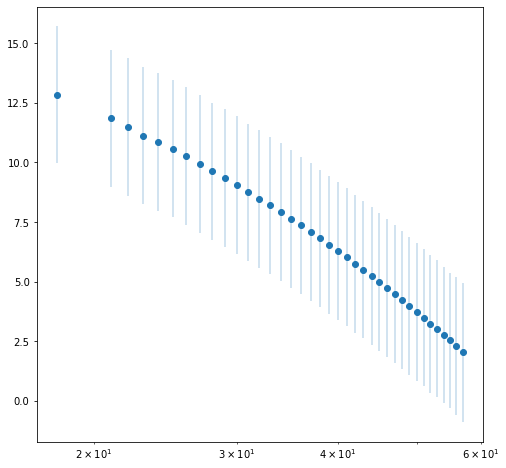

100%|██████████| 1507/1507 [00:01<00:00, 923.19it/s]


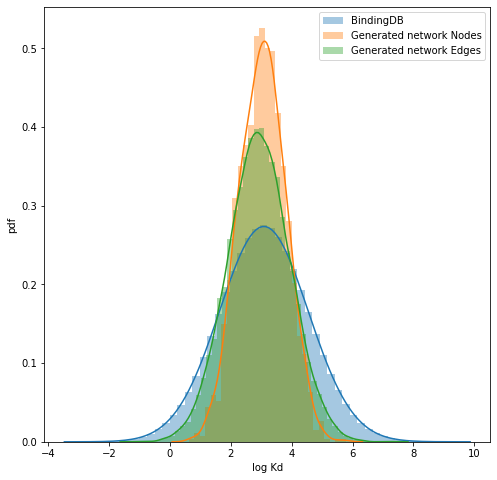

Threshold:  830.047093392166


In [51]:
network_data_BC_P, degrees_from_networkP, node_Kd_values_avg_sampledP, MATsampleP = sampling_with_corrP(GP, anti_corr, mean_log_Kd, std_log_Kd,kd_list, p_bind = THR)

100%|██████████| 38/38 [00:00<00:00, 6113.91it/s]

mean log Kd from copula  6.991506751152818
mean log Kd original  7.104581746618654
std log Kd from copula  1.7273054926966838
std log Kd original  3.333633341053326
Correlation between node copula generated k and Kd:  SpearmanrResult(correlation=-0.9588401372418642, pvalue=0.0)
Correlation between copula generated k and <Kd>:  SpearmanrResult(correlation=-0.999562315351789, pvalue=1.1986323932037677e-56)


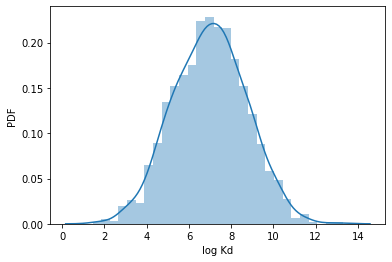

In [52]:
sns.distplot(np.log(node_Kd_values_avg_sampledP))
plt.xlabel('log Kd')
plt.ylabel('PDF')

## Checks on original Kd duistribution and Kd from copula

print('mean log Kd from copula ', np.mean(np.log(node_Kd_values_avg_sampledP)))
print('mean log Kd original ', mean_log_Kd)
print('std log Kd from copula ',np.std(np.log(node_Kd_values_avg_sampledP)))
print('std log Kd original ',std_log_Kd)

print('Correlation between node copula generated k and Kd: ', stats.spearmanr(degrees_from_networkP,node_Kd_values_avg_sampledP))

different_target_annotations_copula = list(set(degrees_from_networkP))
unique_Kd_targets_copula = []

for unique_ann in tqdm(different_target_annotations_copula):
    
    all_Kd_list = []    
    all_indices = get_all_indices(degrees_from_networkP,unique_ann)
    
    for j in all_indices:
        all_Kd_list.append(node_Kd_values_avg_sampledP[j])
        
    unique_Kd_targets_copula.append(np.mean(all_Kd_list))
    
print('Correlation between copula generated k and <Kd>: ', stats.spearmanr(different_target_annotations_copula,unique_Kd_targets_copula))

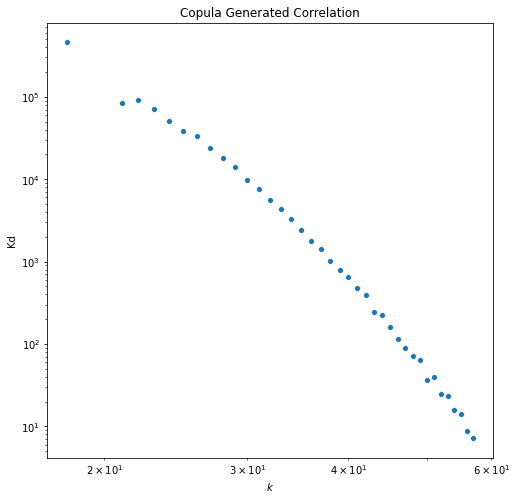

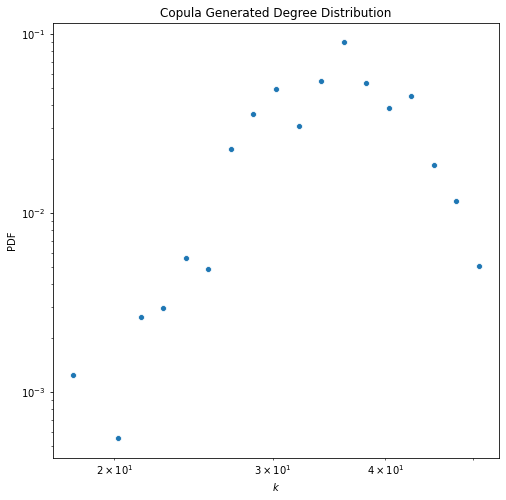

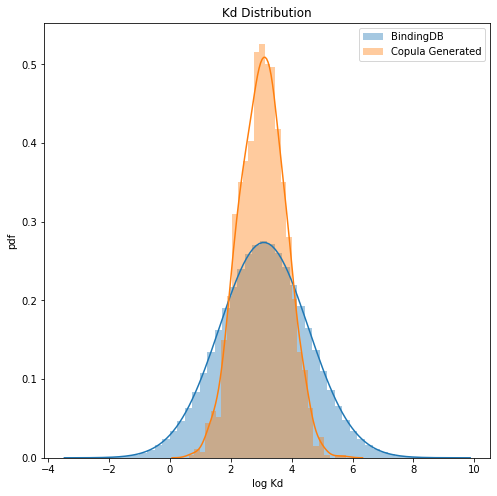

In [53]:
figure(figsize=(8, 8))
ax = sns.scatterplot(different_target_annotations_copula,unique_Kd_targets_copula)
ax.set(title='Copula Generated Correlation',xscale='log',yscale='log',xlabel='$k$',ylabel='Kd')

figure(figsize=(8, 8))
binned_deg_ann, binned_ki_ann = log_binning_distribution(degrees_from_networkP,B = 20)
ax = sns.scatterplot(binned_deg_ann, binned_ki_ann)
ax.set(title='Copula Generated Degree Distribution',xscale='log',yscale='log',xlabel='$k$',ylabel='PDF')

figure(figsize=(8, 8))
ax = sns.distplot(np.log10(remove_zeros_distribution(kd_list)), label='BindingDB', norm_hist=True)
ax = sns.distplot(np.log10(node_Kd_values_avg_sampledP), label='Copula Generated', norm_hist=True)
ax.set(title='Kd Distribution',xlabel='log Kd', ylabel='pdf')
plt.legend()
plt.show()

100%|██████████| 1507/1507 [00:03<00:00, 490.27it/s]


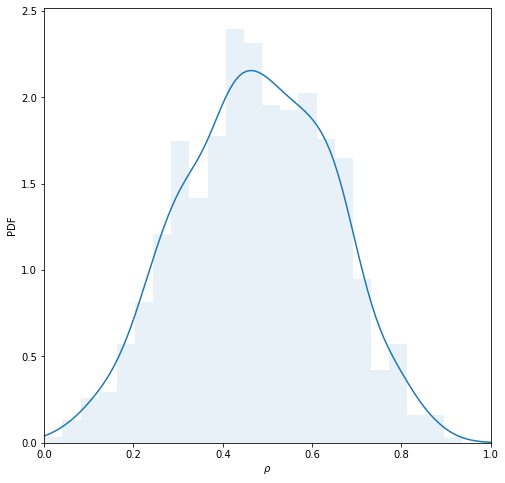

  0%|          | 2/10000 [00:00<12:54, 12.92it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.5010764072701606


  5%|▌         | 507/10000 [00:38<12:01, 13.17it/s]
136it [00:00, 1357.31it/s]

Loops  508
Error margin:  [9.71588605e-06]


8501it [00:06, 1382.04it/s]


AUC:  0.688947228476452
AUP:  0.688527960338344
Transductive performance:
AUC:  0.688947228476452
AUP:  0.688527960338344


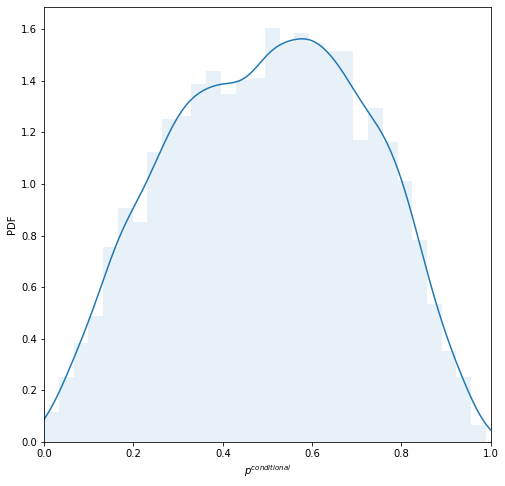

In [54]:
run_configuration_model(network_data_BC_P, loops=10000)

100%|██████████| 1507/1507 [00:03<00:00, 500.21it/s]


Number of zero positive degree  4
Mean positive degree  13.199734571997345
Std positive degree  6.5304594828861
%%%%%%%
Mean negative degree  13.122760451227604
Std negative degree  3.2463842697923493
%%%%%%%
Mean degree  26.32249502322495
Std degree  5.192975924333288


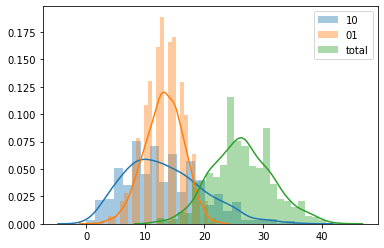

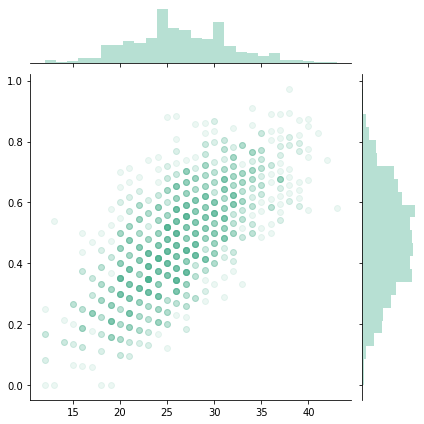

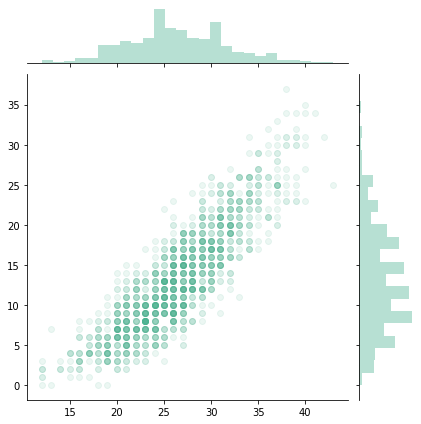

In [55]:
train, test = train_test_split(network_data_BC_P, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              color="#4CB391",
             alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              color="#4CB391",
             alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

# Poisson + No Correlation

## Without fluctuation

  3%|▎         | 47/1507 [00:00<00:03, 464.15it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=0.22507933034248823, pvalue=0.17426035070573986)


100%|██████████| 1507/1507 [00:03<00:00, 477.23it/s]


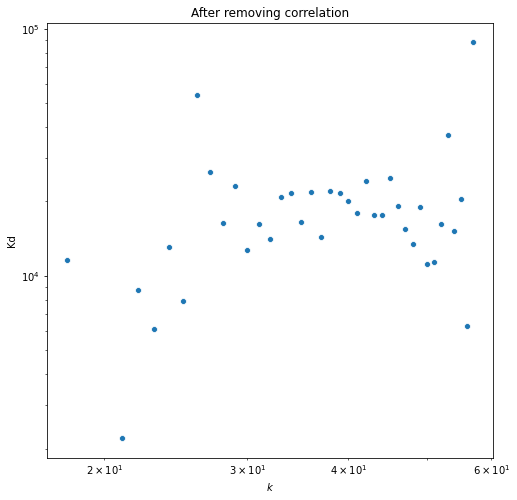

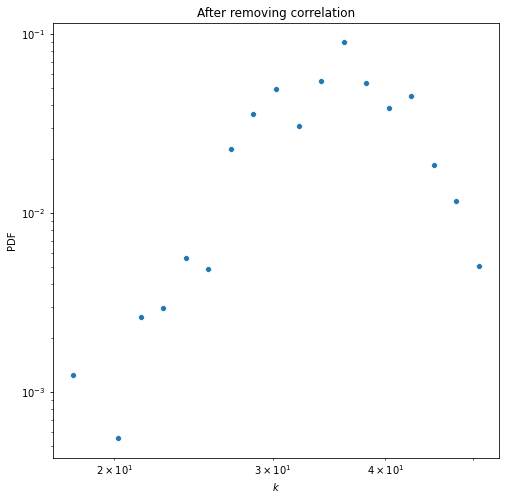

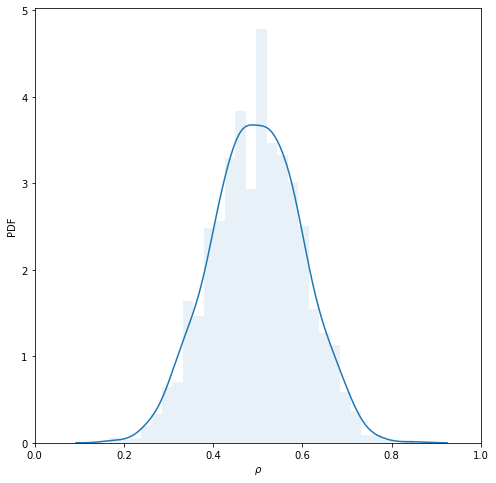

  0%|          | 2/10000 [00:00<14:05, 11.83it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.49631198164813833


  6%|▌         | 591/10000 [00:44<11:53, 13.19it/s]
141it [00:00, 1403.05it/s]

Loops  592
Error margin:  [9.84121899e-06]


8501it [00:06, 1366.76it/s]


AUC:  0.5092494889549616
AUP:  0.501415814418645
Transductive performance:
AUC:  0.5092494889549616
AUP:  0.501415814418645


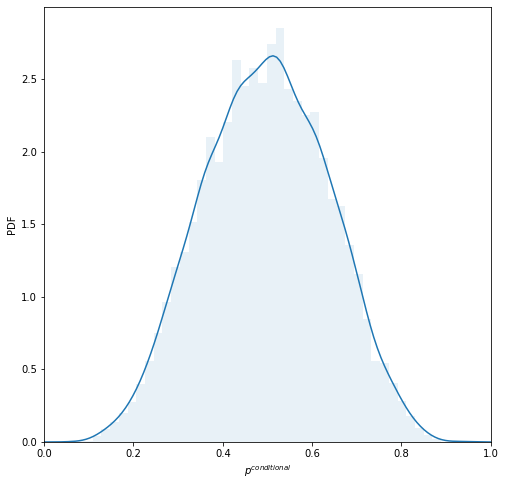

In [56]:
network_dataP_shuffled = remove_correlation_run_configuration_model(network_dataP, precision=10**(-5), loops=10000)

100%|██████████| 1507/1507 [00:03<00:00, 467.40it/s]


Number of zero positive degree  0
Mean positive degree  13.129396151293962
Std positive degree  3.6495236756853595
%%%%%%%
Mean negative degree  13.193098871930989
Std negative degree  3.689941152943839
%%%%%%%
Mean degree  26.32249502322495
Std degree  5.084636514006724


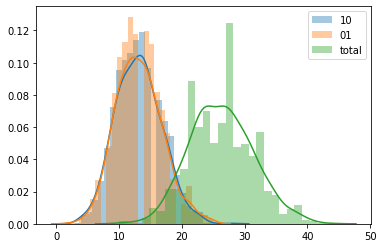

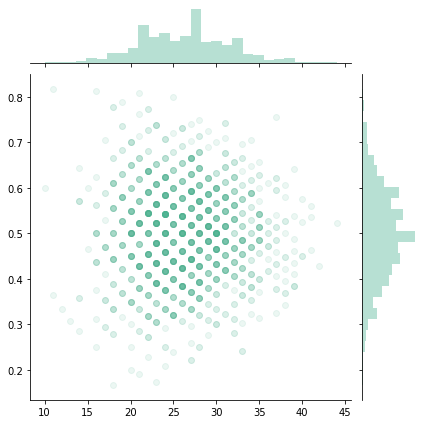

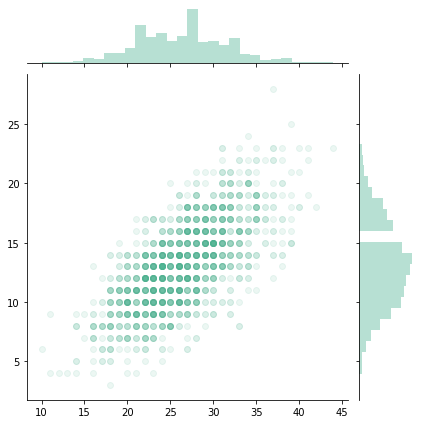

In [57]:
train, test = train_test_split(network_dataP_shuffled, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              color="#4CB391",
             alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              color="#4CB391",
             alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

## With fluctuation

  3%|▎         | 43/1507 [00:00<00:03, 426.47it/s]

Correlation between k and <Kd>:  SpearmanrResult(correlation=0.41306488674909725, pvalue=0.009952076251235826)


100%|██████████| 1507/1507 [00:03<00:00, 481.49it/s]


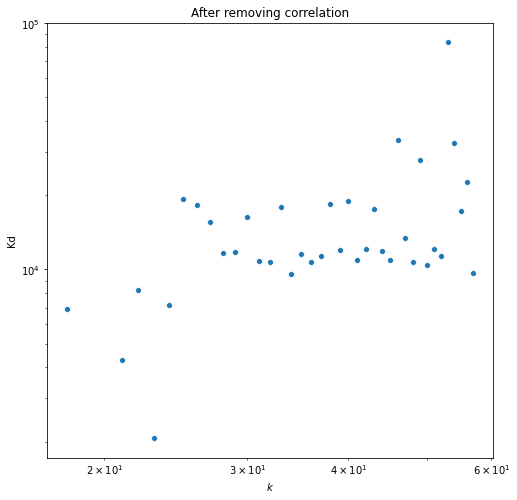

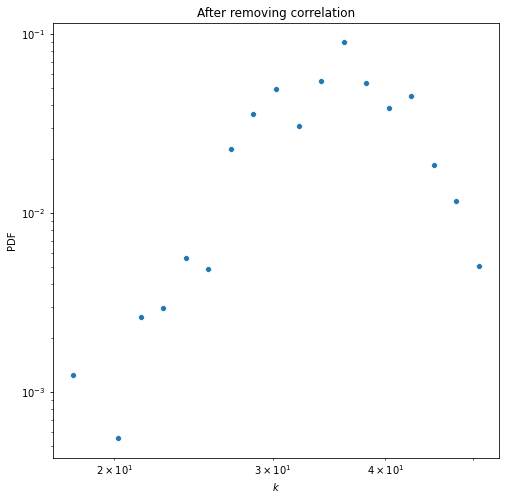

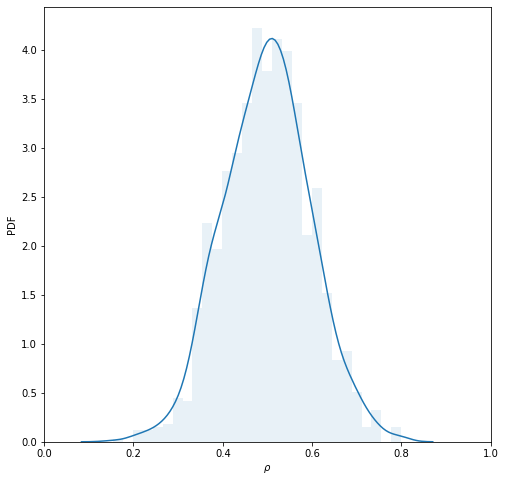

  0%|          | 2/10000 [00:00<13:28, 12.36it/s]

Number of nodes with not positive or negative annotation:  0
Validating p_bind value from binary labels:  0.5010764072701606


  6%|▌         | 590/10000 [00:44<11:53, 13.19it/s]
140it [00:00, 1396.17it/s]

Loops  591
Error margin:  [9.7273292e-06]


8501it [00:06, 1395.35it/s]


AUC:  0.4964545420424535
AUP:  0.5055577725251607
Transductive performance:
AUC:  0.4964545420424535
AUP:  0.5055577725251607


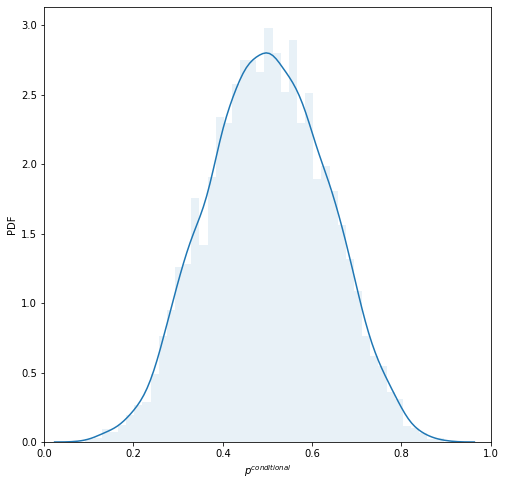

In [58]:
network_data_BC_P_shuffled = remove_correlation_run_configuration_model(network_data_BC_P, precision=10**(-5), loops=10000)

100%|██████████| 1507/1507 [00:03<00:00, 490.78it/s]


Number of zero positive degree  0
Mean positive degree  13.142667551426676
Std positive degree  3.6174324003126346
%%%%%%%
Mean negative degree  13.179827471798275
Std negative degree  3.561784440076786
%%%%%%%
Mean degree  26.32249502322495
Std degree  5.15848798458765


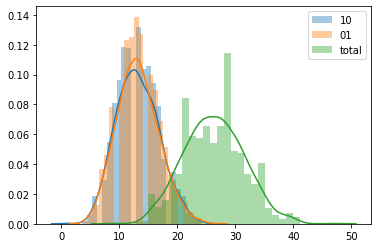

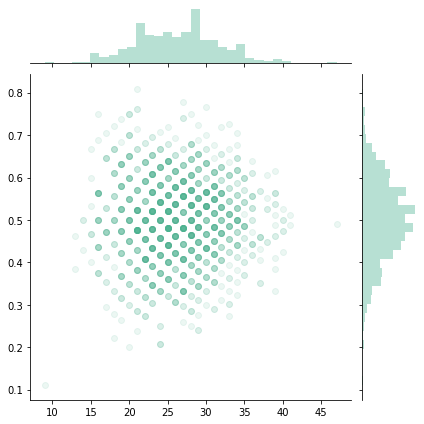

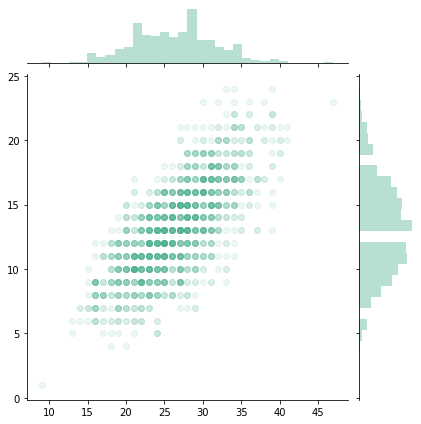

In [59]:
train, test = train_test_split(network_data_BC_P_shuffled, test_size=0.3)

train_nodes = list(set(train['node_1']).union(set(train['node_2'])))
train_nodes_index_map = dict(zip(train_nodes, range(len(train_nodes)))) ## Mapping between training ndoes and indices for selecting from summat matrices

degree_train_1_0 = []
degree_train_0_1 = []

for node in tqdm(train_nodes):
    sub_df = train[(train['node_1'] == node) | (train['node_2'] == node)]
    degree_train_1_0.append(len(sub_df[sub_df['binary_label'] == 1]))
    degree_train_0_1.append(len(sub_df[sub_df['binary_label'] == 0]))
    
sns.distplot(np.array(degree_train_1_0), label='10')
sns.distplot(np.array(degree_train_0_1), label='01')
sns.distplot(np.array(degree_train_1_0)+np.array(degree_train_0_1), label='total')
plt.legend()



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0)/(np.array(degree_train_1_0)+np.array((degree_train_0_1))),
              color="#4CB391",
             alpha=0.1)



sns.jointplot(x=np.array(degree_train_1_0)+np.array((degree_train_0_1)), 
              y=np.array(degree_train_1_0),
              color="#4CB391",
             alpha=0.1)


print('Number of zero positive degree ', sum(np.array(degree_train_1_0)==0))
print('Mean positive degree ', np.array(degree_train_1_0).mean())
print('Std positive degree ', np.array(degree_train_1_0).std())
print('%%%%%%%')

print('Mean negative degree ', np.array(degree_train_0_1).mean())
print('Std negative degree ', np.array(degree_train_0_1).std())
print('%%%%%%%')
print('Mean degree ', np.mean(np.array(degree_train_1_0)+np.array((degree_train_0_1))))
print('Std degree ', np.std(np.array(degree_train_1_0)+np.array(degree_train_0_1)))

100%|██████████| 38/38 [00:00<00:00, 3804.63it/s]


Correlation between k and <Kd>:  SpearmanrResult(correlation=0.41306488674909725, pvalue=0.009952076251235826)


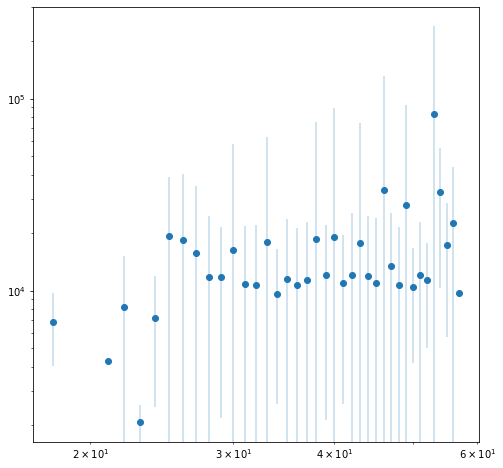

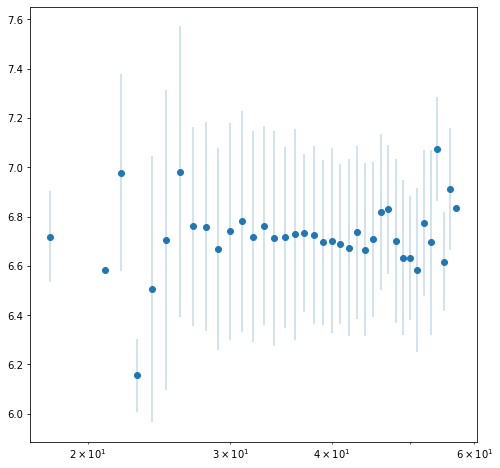

In [60]:
plot_k_Kd_relation(network_data_BC_P_shuffled)